UCL Centre for Advanced Spatial Analysis

CASA0006: Data Science for Spatial Systems

Term 2, 2019

MSc, Spatial Data Science and Visualisation

# Taking Britain's Pulse: Analyzing public sentiment towards Brexit

# Introduction

In the 21st century, information and communication technologies have evolved to the point where digital data transfer is effectively instantaneous on Earth (Satariano 2019). Public conversation now occurs on a global level, focused on a number of platforms that provide the physical and informational architecture to enable real-time discourse. Twitter, one of the most used digital forums for discourse, currently has hundreds of millions of users (Kastrenakes 2019).

The Cambrian explosion of data creation has created opportunities for data scientists to mine data for information. Researchers have analyzed Brexit vote outcomes at the district level (Becker et al 2017) and analyzed tweets related to the topic (Porcaro and Muller 2016). In this analysis we analyze a fusion of spatial, quantitative and natural language datasets in an effort to assess public sentiment towards Brexit across the UK. 

# Research Question

How does current public sentiment towards Brexit vary across the UK, and relate to voting outcomes of the 2016 referendum?

# Data Collection, Validation and Cleaning

A number of spatial and natural language datasets were collected, manipulated and joined to perform our analysis. First, the results of the Brexit referendum were retrieved from the UK Electoral Commission website (Electoral Commission 2019). A spatial dataset containing polygons representing the UK parliamentary constituencies that participated in the Brexit referendum was collected from Ordnance Survey (ONS Geography 2018, Ordnance Survey Northern Ireland 2015) and Natural Earth (Natural Earth 2019) and prepared. Finally, tweets from each district were collected and analyzed, providing the basis for our spatial analysis of public sentiment towards Brexit as of April 2019. 

Standard  and installed Python (`v3.6.7`) libraries used to collect and prepare data for analysis include:

- `re v2.2.1`
- `os`
- `csv v1.0`
- `math`
- `json v2.0.9`
- `time`
- `numpy v1.16.2`
- `scipy v1.2.1`
- `tweepy v3.7.0`
- `pandas v0.24.2`
- `IPython v7.4.0`
- `seaborn v0.9.0`
- `shapely v1.6.4.post2`
- `requests v2.21.0`
- `textblob v0.15.3`
- `warnings`
- `geopandas v0.4.1`
- `matplotlib v3.0.3`
- `statsmodels v0.9.0`

Due to volumes of data collected, along with request rate limits on the APIs utilized, this notebook will demonstrate functionality of data scraping code but load data in from the included `../data/` directory. To recreate the workflow employed in the collection with adaptations to accommodate rate limits, including the analysis and visualization process, set the `execute` variable to `"demo"`. To recreate the full workflow, set it to `"full"`.

In [1]:
import re
import os
import csv
import math
import json
import time
import numpy as np
import scipy
import tweepy
import pandas as pd
import seaborn as sns
import shapely
from shapely import wkt
import geoplot as gplt
import requests
from textblob import TextBlob
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from statsmodels.graphics.tsaplots import plot_acf

# Configure matplotlib parameters
%matplotlib inline
plt.style.use('ggplot')

# Silence warnings
warnings.filterwarnings('ignore')

In [2]:
execute = 'local'
# execute = 'demo'
# execute = 'full'

if execute == 'local':
    print('Local mode will read files from directories included in our submission.\
          \nThis will reproduce the results presented.')
    
if execute == 'demo':
    print('Demo mode will call APIs, but with severely constrained volumes.\
          \nThis is to demonstrate functionality of code, and will *not* produce in similar results.')

if execute == 'full':
    print('Full mode will recreate the workflow employed in our data collection and cleaning process.\
          \nThis will take several hours to execute and will *not* produce identical results.')

Demo mode will call APIs, but with severely constrained volumes.          
This is to demonstrate functionality of code, and will *not* produce in similar results.


In [3]:
# A few helper functions to get started:

# To display complete dataframes:
def display_df_html(_df):
    display(HTML(_df.to_html()))
    
# To estimate a polygon's diameter:
def approx_diameter_KM(_polygon):
    # if projection is epsg:4326
    bbox = list(_polygon.bounds)
    pt1 = shapely.geometry.Point([bbox[0], bbox[1]])
    pt2 = shapely.geometry.Point([bbox[2], bbox[3]])
    
    return 6371 * (pt1.distance(pt2) * math.pi / 180.)

# Adapted from https://stackoverflow.com/questions/17371652/tweepy-twitter-api-not-returning-all-search-results
def get_tweets(_query, _geo_extent, _n, _api, _area):
    print("Fetching tweets for", _area)
    
    max_queries = 100  # arbitrarily chosen value

    # tweet_mode='extended' ensures full tweet text is returned
    tweets = tweet_batch = _api.search(q=_query,geocode=_geo_extent, tweet_mode='extended', count=_n)
    
    ct = 1
    while len(tweets) < _n and ct < max_queries:
        print(len(tweets))
        tweet_batch = _api.search(q=_query,  geocode=_geo_extent,
                                 count = _n - len(tweets),
                                 max_id=tweet_batch.max_id)
        tweets.extend(tweet_batch)
        ct += 1
        
        # To avoid overly repetitive calls if no tweets are returned:
        if ct > 5 and len(tweets) == 0:
            return None
        
    return tweets

# Adapted from http://blog.impiyush.com/2015/03/data-analysis-using-twitter-api-and.html
def tweepy_search_to_df(_key, _tweets):

    df = pd.DataFrame()

    if _tweets == None:
        df.loc[0,'searchArea'] = _key
        df.loc[0, 'tweetID'] = "No Tweets Found"
        return df
        
    df['tweetID'] = [tweet.id for tweet in _tweets]
    df['searchArea'] = _key

    try:
        df['tweetFullText'] = [tweet.full_text for tweet in _tweets]
    except:
        pass
    try:
        df['tweetText'] = [tweet.text for tweet in _tweets]
    except:
        pass
#     df['tweetFullText'] = [tweet.full_text for tweet in _tweets]
    df['tweetRetweetCt'] = [tweet.retweet_count for tweet in _tweets]
    df['tweetFavoriteCt'] = [tweet.favorite_count for tweet in _tweets]
    df['tweetSource'] = [tweet.source for tweet in _tweets]
    df['tweetCreated'] = [tweet.created_at for tweet in _tweets]
    df['tweetCoordinates'] = [tweet.coordinates for tweet in _tweets]
    df['tweetGeo'] = [tweet.geo for tweet in _tweets]
    df['tweetPlace'] = [tweet.place for tweet in _tweets]

    df['userID'] = [tweet.user.id for tweet in _tweets]
    df['userScreen'] = [tweet.user.screen_name for tweet in _tweets]
    df['userName'] = [tweet.user.name for tweet in _tweets]
    df['userCreateDt'] = [tweet.user.created_at for tweet in _tweets]
    df['userDesc'] = [tweet.user.description for tweet in _tweets]
    df['userFollowerCt'] = [tweet.user.followers_count for tweet in _tweets]
    df['userFriendsCt'] = [tweet.user.friends_count for tweet in _tweets]
    df['userLocation'] = [tweet.user.location for tweet in _tweets]
    df['userTimezone'] = [tweet.user.time_zone for tweet in _tweets]

    return df

def geocode_tweets_by_location(_df_unique_locations, _start, _end, _token='430b8138a49ab0'):
    
    url = "https://us1.locationiq.com/v1/search.php"
    
    data = {
        'key': _token,
        'format': 'json'
    }
    
    dict_output = {}

    for location in _df_unique_locations:
        data['q'] = location
        response = requests.get(url, params=data)
        
        place = json.loads(response.text)
        
        dict_output[location] = place
        
        time.sleep(1) # due to API limit

    
    # Write to file each iteration in case of interruption
    # Will read into dataframe next
    with open('../outputs/locations/' + execute + '-' + str(_start) + '-' + str(_end) + '.json', 'w') as of:
        json.dump(dict_output, of)

def bbox_centroid(_tweepy_Place):

    lon = np.mean(np.array(_tweepy_Place.bounding_box.coordinates[0]).T[0])
    lat = np.mean(np.array(_tweepy_Place.bounding_box.coordinates[0]).T[1])
    return [lon, lat]

def clean_tweet(_tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        Directly from https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) \
                                    |(\w+:\/\/\S+)", " ", _tweet).split()) 
    
def get_district_code(_gdf, _row):
    try:
        return _gdf[_gdf['geometry'].contains(_row.loc['coordinates'])]['lad17cd'].values[0]
    except:
        return None
    


### Referendum Results

A dataset from the UK Electoral Commission containing information about 382 constituencies includes several quantitative dimensions pertaining to official vote tallies, such as percent turnout, number of valid votes, and counts of votes for Leave and Remain (Electoral Commission 2019). Notably, Northern Ireland - composed of 18 constituencies - was reduced to one in the Electoral Commission's dataset.

In [4]:
# Adapted from https://therenegadecoder.com/code/how-to-check-if-a-file-exists-in-python/


if os.path.isfile('../data/EU-referendum-result-data.csv') and execute == 'local':
    print("Reading referendum results from local file.")
    
    brexit_results = pd.read_csv('../data/EU-referendum-result-data.csv').rename(columns={"Area_Code":"lad17cd"})
    
else:    
    print("Downloading, then reading referendum results from downloaded file.")

    results_url = 'https://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv'    
    results_response = requests.get(results_url, allow_redirects=True)
    
    open('../data/EU-referendum-result-data-dl.csv', 'wb').write(results_response.content)
    
    brexit_results = pd.read_csv('../data/EU-referendum-result-data-dl.csv').rename(columns={"Area_Code":"lad17cd"})

    print("Successfully downloaded.")

display_df_html(brexit_results.head())

Downloading, then reading referendum results from downloaded file.
Successfully downloaded.


,id,Region_Code,Region,lad17cd,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
0,108,E12000006,East,E06000031,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
1,109,E12000006,East,E06000032,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
2,112,E12000006,East,E06000033,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
3,113,E12000006,East,E06000034,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
4,110,E12000006,East,E06000055,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


In [5]:
# Excluding unused columns
brexit_results = brexit_results[[ 'Region_Code', 'Region', 'lad17cd', 'Area', 'Electorate', 
                                 'ExpectedBallots', 'VerifiedBallotPapers', 'Valid_Votes', 
                                 'Remain', 'Leave', 'Pct_Turnout', 'Pct_Remain', 'Pct_Leave', 
                                 'Pct_Rejected']]

### Spatial Data

We collected spatial data representing each of the district areas included in the Electoral Commission dataset. Data describing 380 district areas on the isle of Great Britain were accessed on the Office of National Statistics Open Geography Portal (ONS Geography 2018). Geodata of the 18 parliamentary constituencies in Northern Ireland was downloaded from the Ordnance Survey Northern Ireland's Open Data repository (Ornance Survey Northern Ireland 2015). A geometry representing Gibraltar was extracted from the Natural Earth 10m Cultural Vectors shapefile (Natural Earth 2019). Due to low resolution, as well as the relative small size of Gibraltar, we chose to include the geometry for analysis when possible, but to exclude it from geographic visualizations.

After reprojecting the geometries to WGS 84 to ensure compatibility with other spatial datasets, we joined the referendum results data with the Local Area District geometries dataset on the `lad17cd` column. The resultant dataset contained spatial, quantitative and natural language data about each of the 382 constituencies that participated in the referendum. Dimensions included a Local Authority District code (`lad17cd`), the district's name, quantitative dimensions including each districts's area, longitude and latitude, and information describing each district's geometry.

Other dimensions to the dataset were then calculated, to serve in our analysis. These included a geometry's centroid and approximate diameter, to be used as a geographic dimension in our queries to the Twitter API, as well as each district centroid's distance to Westminster, the British capital. The returned value represents distance in decimal degrees; for our purposes only relative distances were relevant, making conversion to units of length (i.e. kilometers or miles) unnecessary.  Each district's voting age population density by land area was also calculated, as was `Pct_Delta` numerical value, representing the spread between the proportion of voters selecting Leave versus Remain. Negative `Pct_Delta` values indicate a majority voted to Leave.

In [6]:
# Electoral boundaries from 
# https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2017-full-clipped-boundaries-in-great-britain

# Read in and reproject areas
gb_areas = gpd.read_file('../data/Local_Authority_Districts_December_2017_Full_Clipped_Boundaries_in_Great_Britain/Local_Authority_Districts_December_2017_Full_Clipped_Boundaries_in_Great_Britain.shp')
gb_areas = gb_areas.to_crs({'init': 'epsg:4326'})

# Read in forgotten geometries
# Northern Ireland data from https://osni-spatial-ni.opendata.arcgis.com/datasets/ef212a5825514aa8b39259e54cbe87b1_3
ireland = gpd.read_file('../data/OSNI_Open_Data_Largescale_Boundaries__Parliamentary_Constituencies_2008/OSNI_Open_Data_Largescale_Boundaries__Parliamentary_Constituencies_2008.shp')

# Gibraltar, from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
gibraltar = gpd.read_file('../data/gibraltar/gibraltar.shp')

In [7]:
ireland['lad17cd'] = 'N92000002'
ireland_dissolved = ireland.dissolve(by='lad17cd').reset_index()
ireland_dissolved['lad17nm'] = "Northern Ireland"

uk_areas = gb_areas.append(ireland_dissolved[['lad17cd', 'geometry', 'lad17nm']], sort=False)

In [8]:
areas_results = uk_areas.merge(brexit_results, on=["lad17cd"], how='outer')

In [9]:
# And add Gibraltar
gib_idx = areas_results.index[areas_results['lad17cd'] == 'GI'].tolist()[0]
areas_results.loc[gib_idx,'geometry'] = gibraltar.loc[0,'geometry']
areas_results.loc[gib_idx,'lad17nm'] = 'Gibraltar'

In [10]:
areas_results['approx_diameter'] = areas_results.apply(lambda row: approx_diameter_KM(row['geometry']), axis=1)
areas_results['centroid'] = areas_results['geometry'].centroid

london_centroid = areas_results[areas_results['Area'] == 'Westminster']['geometry'].centroid.values[0]
areas_results['dist_to_capital'] = gpd.GeoSeries(areas_results['centroid']).distance(london_centroid)

areas_results['Pct_Delta'] = areas_results['Pct_Remain'] - areas_results['Pct_Leave']
areas_results['pop_density'] = areas_results['Electorate'] / areas_results['st_areasha']

In [11]:
# A boolean series to exclude Gibraltar from geographic plots
without_gibraltar = areas_results['lad17nm'] != "Gibraltar"

In [12]:
# Assigning each district to its home nation, an additional category for analysis

areas_results.loc[areas_results['Region'] == 'Wales', 'home_nation'] = 'Wales'
areas_results.loc[areas_results['Region'] == 'Scotland', 'home_nation'] = 'Scotland'
areas_results.loc[areas_results['Region'] == 'Northern Ireland', 'home_nation'] = 'Northern Ireland'
areas_results.loc[areas_results['lad17nm'] == 'Gibraltar', 'home_nation'] = "British Overseas Territory"
areas_results.loc[areas_results['home_nation'].isnull(), 'home_nation'] = 'England'

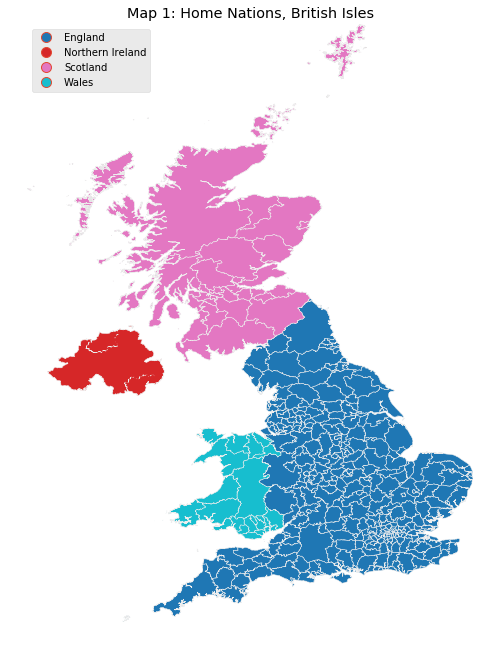

In [13]:
# A quick visual check to ensure that spatial data is loaded properly
# We assign the return value to `_` to silence output
_ = gplt.choropleth(areas_results[without_gibraltar], 
                    hue='home_nation', 
                    cmap='tab10', 
                    categorical=True, 
                    figsize=(8,11), 
                    legend=True)

_ = plt.title('Map 1: Home Nations, British Isles')

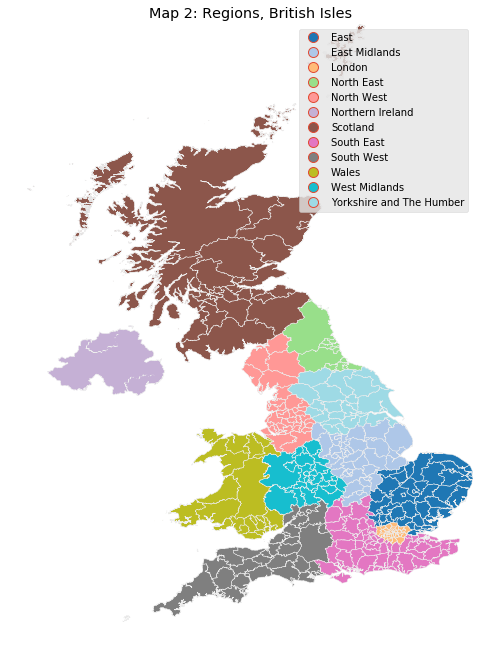

In [14]:
_ = gplt.choropleth(areas_results[without_gibraltar], 
                    hue='Region', 
                    cmap='tab20', 
                    categorical=True, 
                    figsize=(8,11), 
                    legend=True, 
                    legend_kwargs={'loc':1})

_ = plt.title('Map 2: Regions, British Isles')

## Twitter Data Collection

Tweets from across the UK were collected in an effort to collect a snapshot of public sentiment towards Brexit in April 2019. This was a poignant moment in the British political conversation: the UK's exit from the EU had been extended (European Council 2019), but much uncertainty remained regarding what policymakers and residents could expect (BBC 2019). Twitter is an open platform; anyone can post nearly anything. The company has little capacity or, for that matter, capability to ensure that users are honestly reporting their locations or including appropriate hashtags in their tweets. Aware that we would likely collect much noise, we proceeded with our data collection process.

### Authenticating the API

An API key and secret was generated through the Twitter account interface and used to authenticate requests issued by the `tweepy` API (Roesslin 2010), a Python interface with Twitter's API. Twitter's Standard API is rate limited; tweepy's `API` class includes a `wait_on_rate_limit` parameter to automatically handle delays in responses. However, anticipating the time it would take our collection scripts to execute, we wrote each batch of tweets downloaded to disk as `.pkl` files, which preserve object hierarchies by serializing them. This approach protects against data loss that would occur if our script was disrupted mid-execution. We repeated this pattern in other lengthy processes.

### Query Parameters

#### String Matching

Our queries were constrained to tweets containing the string "#brexit", an indication that the contributor intended for it to be included in the conversation on the topic. We also opted to exclude reposts by excluding tweets containing "RT" ("retweet") in the tweet text. 

#### Geography

For each district area under consideration, we sought to download 1000 tweets from within an estimation of that geometry's geographic area. This was performed by specifying that only tweets within a radius of each district's centroid be returned. This radius was equivalent to half of the distance between opposing corners of the geometry's bounding box.  While imperfect, this approach served our purposes within the constraints in geospatial querying imposed by the design of Twitter's API - the company does not support more sophisticated geospatial queries. 

In [15]:
# Prepare tweepy API instance

# Adapted from:
# https://tweepy.readthedocs.io/en/v3.5.0/auth_tutorial.html
# https://gist.github.com/vickyqian/f70e9ab3910c7c290d9d715491cde44c

if execute != 'local':
    consumer_tokens = {
        "api_key": "25rMCGR2wG8ysmr1DbyrYSnli", 
        "secret": "P1rn2n85LMNYLSMrKg4mio7lzj6Ck5nAmS3uu075AorkxE1wqo"
    }

    access_tokens = {
        "token": "796917021619453952-iFMWzz2ZwoToaytQff9PKLjmjrGwm0Z",
        "secret": "euTbS1ORuJxKujPVTiho3zXcB0Rbgqu0Ga5JXSfyv3rxs"
    }

    auth = tweepy.OAuthHandler(consumer_tokens['api_key'], consumer_tokens['secret'])
    auth.set_access_token(access_tokens['token'], access_tokens['secret'])

    twitter_api = tweepy.API(auth,wait_on_rate_limit=True)

    # Instantiate holder lists for data from API
    errors = []
    dfs = []
    
    if execute == 'demo':
        num_tweets = 10
    elif execute == 'full':
        num_tweets = 1000
    
    # Loop through districts and fetch tweets from each 
    for i in range(int(len(areas_results) / 10) + 1):

        for area in areas_results[i * 10: i * 10 + 10].iterrows():

            centroid = list(area[1].geometry.centroid.coords)[0]
            extent = str(round(centroid[1],4)) + ',' + str(round(centroid[0], 4)) + ',' + str(round(area[1].approx_diameter / 2, 4)) + 'km'

            tweets = get_tweets("#brexit -RT", extent, num_tweets, twitter_api, area[1]['lad17cd'])    

            if tweets:
                dfs.append(tweets)
                df = tweepy_search_to_df(area[1]['lad17cd'], tweets)
                df.to_pickle('../outputs/master/pickles/' + execute + '-' + area[1]['lad17cd'] + '-' + str(len(df)) + '.pkl')


    print("Tweets successfully read into `df_tweets` dataframe")

Fetching tweets for E06000001
Fetching tweets for E06000002
Fetching tweets for E06000003
Fetching tweets for E06000004
Fetching tweets for E06000005
Fetching tweets for E06000006
Fetching tweets for E06000007
4
4
8
8
9
Fetching tweets for E06000008
Fetching tweets for E06000009
Fetching tweets for E06000010
Fetching tweets for E06000011
9
Fetching tweets for E06000012
Fetching tweets for E06000013
8
Fetching tweets for E06000014
Fetching tweets for E06000015
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
Fetching tweets for E06000016
8
9
Fetching tweets for E06000017
Fetching tweets for E06000018
8
9
9
Fetching tweets for E06000019
9
9
Fetching tweets for E06000020
9
Fetching tweets for E06000021
Fetching tweets for E06000022
Fetching tweets for E06000023
Fetching tweets for E06000024
Fetching tweets for E06000025
Fetching tweets for E0

KeyboardInterrupt: 

In [16]:
if execute != 'local':
    dfs_from_pkls = []
    for file in os.listdir('../outputs/master/pickles/'):
        if execute in file:
            dfs_from_pkls.append(pd.read_pickle('../outputs/master/pickles/' + file))

    df_tweets = pd.concat(dfs_from_pkls)
    df_tweets = df_tweets[~df_tweets['tweetFullText'].isnull()]

else:
    df_tweets = pd.read_pickle('../outputs/master/df_tweets.pkl')

print("Tweets successfully read into `df_tweets` dataframe")

Tweets successfully read into `df_tweets` dataframe


In [17]:
df_tweets = df_tweets.drop_duplicates(subset='tweetID')

In [18]:
n_unique_tweets = len(df_tweets)
print(str(n_unique_tweets) + ' unique tweets were collected from Twitter\'s API')

pct_with_place = len(df_tweets.loc[~df_tweets['tweetPlace'].isnull(), 'tweetPlace']) / len(df_tweets)
print(str(round(pct_with_place * 100, 2)) + '% of unique tweets scraped contained a Place object.')

180 unique tweets were collected from Twitter's API
22.78% of unique tweets scraped contained a Place object.


## Geocoding Tweets

According to Twitter's documentation, "the search API will first attempt to find Tweets which have lat/long within the queried geocode, and in case of not having success, it will attempt to find Tweets created by users whose profile location can be reverse geocoded into a lat/long within the queried geocode, meaning that is possible to receive Tweets which do not include lat/long information." (Twitter Developers 2019). 

With 37,095 full unique tweets scraped from the Twitter servers, we used the LocationIQ geocoding API to geocode user locations, thereby assigning longitude and latitude float values to each tweet to serve as the basis for subsequent spatial analyses. LocationIQ was used due to more generous daily geocoding allowances than Google's Geolocation API. To reduce query volumes, only coordinates for unique locations were retrieved.

We first calculated the centroids of the bounding boxes provided by Twitter, assigning longitude and latitude values to the 16.83% of tweets containing a location. The remaining tweets' `userLocation` dimension was passed to the geocoding API. The returned coordinates were then joined with the original tweets dataframe on `userLocation`.

In [19]:
# Iterate through segments of the locations_to_geocode series, writing results to disk at intervals.

if execute != 'local':
    df_tweets_to_geocode = df_tweets[df_tweets['tweetPlace'].isna()]
    locations_to_geocode = df_tweets_to_geocode['userLocation'].unique()
    print('Geocoding', str(locations_to_geocode), 'locations ......')
    for i in range(0, math.floor(len(locations_to_geocode) / 25) + 1 ):
        start = i  * 25
        end = start + 25

        geocode_tweets_by_location(locations_to_geocode[start : end], start, end)
    
    print("Locations successfully geocoded and written to disk!")
    
    

Geocoding ['Middlesbrough, England' 'Redcar, England' 'Middlesbrough' 'Teesside'
 'Stokesley, England' 'Middlesbrough ' 'Windsor UK' 'Gerrards Cross'
 'Slough' 'Slough, England' 'Hartlepool, England' 'Bristol, England'
 'Bristol' 'Bristol, UK' 'Bournemouth, England' 'Bournemouth'
 'Bournemouth UK' 'Bournemouth, England, UK' 'Poole, Great Britain'
 'Stoke-on-Trent, England' 'Stoke' 'Blackpool, England' 'Blackpool'
 'Blackpool, UK' 'Thornton Cleveleys' 'Stamford, England' 'Corby, England'
 'Corby' 'Darlington, England' 'Darlington' 'Bishop Auckland, England'
 'Henley-on-Thames, UK' 'Wokingham, England' 'Henley on Thames'
 'Wokingham' 'Spalding Lincs' 'Whittlesey' 'Ramsey, England'
 'Peterborough, UK' 'Peterborough, United Kingdom' 'Plymouth UK'
 'Plymouth' 'Plymouth, England' 'Torpoint, Cornwall, England'
 'Hull, England' 'Hull united kingdom' 'East Hull ' 'Kingston upon Hull'
 'Hull, UK' 'Newport, Wales, UK' 'Christchurch, Dorset' 'Cleethorpes'
 'Bolton, England' 'Bolton, England.' 'Bla

In [20]:
# Read the data back in from disk

location_dicts = []
for file in os.listdir('../outputs/locations/'):
    if execute in file:
        with open('../outputs/locations/' + file, 'r') as f:
            location_dicts.append(json.load(f))

In [21]:
places = []
ct = 0
for d in location_dicts:
    for key in d.keys():
        try:
            ct += 1
            d_tmp = d[key][0]

            d_tmp['location'] = key
            places.append(d_tmp)
        except KeyError:
            print('KeyError:')
            print("-~" + key + "~-")
            print(d[key])
print(ct, 'unique locations geocoded.')

df_places = pd.DataFrame(data=places)
# df_places.to_csv('../outputs/geocoded_locations.csv')

df_places.head()

17 unique locations geocoded.


,boundingbox,class,display_name,icon,importance,lat,licence,location,lon,osm_id,osm_type,place_id,type
0,"[50.6944198, 50.7744198, -1.80512, -1.72512]",place,"Christchurch, South West England, England, BH2...",https://locationiq.org/static/images/mapicons/...,0.410000,50.7344198,https://locationiq.com/attribution,"Christchurch, Dorset",-1.76512,14600264,node,109228,town
1,"[53.5172068, 53.5972068, -0.0689969, 0.0110031]",place,"Cleethorpes, North East Lincolnshire, Yorkshir...",https://locationiq.org/static/images/mapicons/...,0.539395,53.5572068,https://locationiq.com/attribution,Cleethorpes,-0.0289969,27583967,node,146069,town
2,"[53.5228655, 53.6460294, -2.6286157, -2.3370404]",boundary,"Bolton, Greater Manchester, North West England...",https://locationiq.org/static/images/mapicons/...,0.663291,53.577694,https://locationiq.com/attribution,"Bolton, England",-2.4288874,146937,relation,208898733,administrative
3,"[53.5228655, 53.6460294, -2.6286157, -2.3370404]",boundary,"Bolton, Greater Manchester, North West England...",https://locationiq.org/static/images/mapicons/...,0.663291,53.577694,https://locationiq.com/attribution,"Bolton, England.",-2.4288874,146937,relation,214324301,administrative
4,"[53.7097193, 53.7897193, -2.5197543, -2.4397543]",place,"Blackburn, Blackburn with Darwen, North West E...",https://locationiq.org/static/images/mapicons/...,0.743146,53.7497193,https://locationiq.com/attribution,"Blackburn, England",-2.4797543,21664801,node,117244,town


In [22]:
# Join geocoded locations to tweets dataframe
df = df_tweets.join(df_places.set_index('location'), on='userLocation').reset_index().drop(columns=['index'])

In [23]:
# Extract longitude and latitude floats from Place objects returned from tweepy, where they exist
df.loc[~df['tweetPlace'].isnull(), 'coords'] = df.loc[~df['tweetPlace'].isnull(), 'tweetPlace'].apply(bbox_centroid)
df.loc[~df['tweetPlace'].isnull(), 'lon'] = np.array(df.loc[~df['tweetPlace'].isnull(), 'coords'].values.tolist()).T[0]
df.loc[~df['tweetPlace'].isnull(), 'lat'] = np.array(df.loc[~df['tweetPlace'].isnull(), 'coords'].values.tolist()).T[1]

# Data Analysis

## Sentiment Analysis 

A computational approach to assessing tweet sentiment was taken, and the district of the tweeter was determined from their stated location when tweets were not geotagged. This information comes with many constraints, discussed below, but may offer insight into the perceptions of a slice of the British public into Brexit.

Computational methods for assessing the sentiment of text have been evolving since the early 20th century; advancements in storage devices and processing speeds have resulted in an rapid increase in research and, as a result, capabilities (Mantyla 2018). Our research is focused on understanding public sentiments towards Brexit in April 2019. The complexity of the task of distilling the subjective quality of a statement's sentiment into a single quantitative value cannot be understated; employing an algorithm to do so, rather than a human, is even more difficult. While we hesitate to take what we see might be a reductionist approach, we conduct our analysis acknowledging the limitations of the method, hopeful that some insight can be gleaned about aggregated local attitudes towards the topic. 

To assess sentiment we utilized the textblob python library (Loria 2019). The open-source library is built on top of the Natural Language Toolkit (NLTK Project 2019). Specifically, we used the library by creating instances of the `TextBlob` class for each tweet. When initiated this class calculates a `sentiment` attribute for the string of English text passed in, which provides a measure of `polarity` in the range \[-1.0, 1.0\] - strongly negative to strongly positive -  and `subjectivity`, from \[0.0,1.0\] - objective to subjective. Links and special characters are unlikely to contribute to the tweet's sentiment, and were removed using the `clean_tweet()` function (Kumar 2019). Each tweet's full text was then classified, and `tweetPolarity` and `tweetSubjectivity` dimensions were added to the dataset. 

The TextBlob sentiment analysis functionality is provided by training a Naive Bayes classifier on the NLTK-provided corpus of movie reviews, which are tagged as "positive" and "negative". While an efficient and relatively successful approach (Zhang 2004), it is important to note the constraints of this supervised machine learning algorithm for the task: it is insensitive to complex sentence structures including multiple subjects and attitudes, sarcasm, detecting the subjective position of the message creator and so on. Additionally, detecting the subject at which a tweet is directed is beyond the scope of this investigation, but it should be noted that two tweets with equal sentiment scores may be referring to different aspects of the Brexit debate, posted by people with divergent positions on the issue. Instead, the Naive Bayes classifier assigns polarity and subjectivity values based on the appearance of a tokenized series of words in the training set. 

In [24]:
# Drop duplicates
df = df.drop_duplicates('tweetID')

# Drop @ replies
df = df[df['tweetFullText'].str[0] != '@']

In [25]:
# Pattern in .apply() from Kumar 2019
df['tweetPolarity'] = df.apply(lambda row: TextBlob(clean_tweet(row['tweetFullText'])).sentiment[0], axis=1)
df['tweetSubjectivity'] = df.apply(lambda row: TextBlob(clean_tweet(row['tweetFullText'])).sentiment[1], axis=1)

In [26]:
df['words_in_tweet'] = df.apply(lambda row: len(row['tweetFullText'].split(' ')), axis=1)
df['chars_in_tweet'] = df.apply(lambda row: len(row['tweetFullText']), axis=1)

In [27]:
df['lon'] = df['lon'].astype('float')
df['lat'] = df['lat'].astype('float')

In [28]:
df['coordinates'] = list(zip(df['lon'], df['lat']))
df['coordinates'] = df['coordinates'].apply(shapely.geometry.Point)

In [29]:
gdf = gpd.GeoDataFrame(df, geometry='coordinates')

In [30]:

if execute != 'local':
    print("This operation might take a while!!")
    
    # Determine which district a tweet is contained in
    gdf['district_cd'] = gdf.apply(lambda row: get_district_code(areas_results, row), axis=1)
    
    # Exclude tweets not geocoded to within UK voting districts
    gdf = gdf[~gdf['district_cd'].isnull()]
    
    print("Successfully assigned district codes to each tweet and dropped tweets not geocoded to within UK districts.")
else:
    # The set of tweets we performed our analyses on:
    gdf = pd.read_pickle('../outputs/master/gdf_master.pkl')
    print("Successfully read master geodataframe from pickle.")

This operation might take a while!!
Successfully assigned district codes to each tweet and dropped tweets not geocoded to within UK districts.


In [31]:
display_df_html(gdf.head())

,searchArea,tweetCoordinates,tweetCreated,tweetFavoriteCt,tweetFullText,tweetGeo,tweetID,tweetPlace,tweetRetweetCt,tweetSource,userCreateDt,userDesc,userFollowerCt,userFriendsCt,userID,userLocation,userName,userScreen,userTimezone,boundingbox,class,display_name,icon,importance,lat,licence,lon,osm_id,osm_type,place_id,type,coords,tweetPolarity,tweetSubjectivity,words_in_tweet,chars_in_tweet,coordinates,district_cd
14,E06000039,None,2019-04-18 21:41:11,4,cosas curiosas que te puedes encontrar en unas...,None,1118992898979246080,"Place(id='09529a8d92965000', url='https://api....",3,Twitter for iPhone,2016-05-08 10:40:06,Twitter Hello !! Enjoy our tweets with STEAM s...,1149,1135,729259573790580736,Barcelona Madrid København,IGNITE Serious Play,igniteseriousp,None,NaN,NaN,NaN,NaN,NaN,51.463912,NaN,-0.654686,NaN,NaN,NaN,NaN,"[-0.654685864690631, 51.463911773797]",0.300000,0.200000,24,194,POINT (-0.6546858646906309 51.463911773797),E06000040
17,E06000039,None,2019-04-17 13:18:55,6,Remain voters must not get complacent about th...,None,1118504112931340288,"Place(id='29ac72e481808450', url='https://api....",5,Twitter for Android,2018-05-16 22:05:46,A cross party group for citizens of Slough who...,807,1138,996874375583412224,"Slough, South East",Slough for Europe,SloughForEU,None,NaN,NaN,NaN,NaN,NaN,51.514695,NaN,-0.592599,NaN,NaN,NaN,NaN,"[-0.59259935, 51.5146946]",0.070000,0.430000,33,228,POINT (-0.59259935 51.5146946),E06000039
24,E06000025,None,2019-04-24 13:29:22,1,How is @triodosuk \nfinancing change? Supporte...,None,1121043456888070145,"Place(id='7f15dd80ac78ef40', url='https://api....",0,Twitter for Android,2011-08-22 09:06:22,We help people in Devon and Somerset develop t...,1299,1578,359864231,England,SSEDartington,SSEDartington,None,NaN,NaN,NaN,NaN,NaN,51.457877,NaN,-2.585390,NaN,NaN,NaN,NaN,"[-2.5853900000000003, 51.457877]",0.058333,0.147222,33,288,POINT (-2.58539 51.457877),E06000023
45,E06000021,None,2019-04-23 21:55:33,0,Not sure whats worse #ManUnited or #Brexit. Ne...,None,1120808451452620800,"Place(id='5c6453db6560163a', url='https://api....",0,Twitter Web Client,2016-01-01 22:22:38,Born stoke . Live in Blackpool \n19,138,864,4692022572,Uk,Callum Richards,calric1998,None,NaN,NaN,NaN,NaN,NaN,53.019397,NaN,-2.154013,NaN,NaN,NaN,NaN,"[-2.1540125000000003, 53.019396650000004]",-0.112500,0.497222,28,176,POINT (-2.1540125 53.01939665),E06000021
46,E06000021,None,2019-04-23 20:46:07,0,After a fabulous weekend in the glorious sunsh...,None,1120790979315892227,"Place(id='69027b204b9c5c9b', url='https://api....",0,Twitter for iPhone,2009-06-25 23:08:06,"British Punjabi,💕 life with a hot latte, Pro🇪🇺...",1095,1350,50805915,"Newcastle-Un-Lyme, UK & Punjab",Rupa ਮਾਸੀ 🇪🇺 🧬🧪🧫🏃🏻‍♀️👟👚☕️🥂,Massie68,None,NaN,NaN,NaN,NaN,NaN,53.018155,NaN,-2.247237,NaN,NaN,NaN,NaN,"[-2.2472365, 53.0181554]",0.200000,0.500000,22,110,POINT (-2.2472365 53.0181554),E07000195


## Sentiment analysis by district

Aggregating tweet data to the district level will allow us to compare tweet distributions and sentiments across our study area.

In [32]:
gdf_district_summary = gdf[['tweetPolarity', 'tweetSubjectivity', 'district_cd']].groupby('district_cd').describe()

In [33]:
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
gdf_district_summary.columns = ['_'.join(col).strip() for col in gdf_district_summary.columns.values]

In [34]:
areas_results_sentiments = areas_results.join(gdf_district_summary, on='lad17cd')

In [35]:
display(HTML(areas_results_sentiments[[ 'lad17cd', 'lad17nm',
       'Region', 'Area', 'Electorate', 
       'Pct_Turnout', 
       'Remain', 'Pct_Remain', 'Leave', 
       'Pct_Leave', 'Pct_Delta', 'dist_to_capital', 'pop_density', 'tweetPolarity_count',
       'tweetPolarity_mean',
       'tweetSubjectivity_mean']].to_html()))

,lad17cd,lad17nm,Region,Area,Electorate,Pct_Turnout,Remain,Pct_Remain,Leave,Pct_Leave,Pct_Delta,dist_to_capital,pop_density,tweetPolarity_count,tweetPolarity_mean,tweetSubjectivity_mean
0,E06000001,Hartlepool,North East,Hartlepool,70341,65.59,14029,30.43,32071,69.57,-39.14,3.341211,0.000752,NaN,NaN,NaN
1,E06000002,Middlesbrough,North East,Middlesbrough,94612,64.89,21181,34.52,40177,65.48,-30.96,3.208594,0.001756,NaN,NaN,NaN
2,E06000003,Redcar and Cleveland,North East,Redcar and Cleveland,103529,70.26,24586,33.81,48128,66.19,-32.38,3.156875,0.000423,NaN,NaN,NaN
3,E06000004,Stockton-on-Tees,North East,Stockton-on-Tees,141486,71.00,38433,38.27,61982,61.73,-23.46,3.264925,0.000690,NaN,NaN,NaN
4,E06000005,Darlington,North East,Darlington,77662,71.07,24172,43.82,30994,56.18,-12.36,3.338537,0.000393,NaN,NaN,NaN
5,E06000006,Halton,North West,Halton,95289,68.26,27678,42.58,37327,57.42,-14.84,3.140139,0.001205,NaN,NaN,NaN
6,E06000007,Warrington,North West,Warrington,157042,73.36,52657,45.73,62487,54.27,-8.54,3.053038,0.000869,NaN,NaN,NaN
7,E06000008,Blackburn with Darwen,North West,Blackburn with Darwen,100117,65.33,28522,43.66,36799,56.34,-12.68,3.172671,0.000731,1.0,0.300000,0.500000
8,E06000009,Blackpool,North West,Blackpool,102354,65.42,21781,32.54,45146,67.46,-34.92,3.678725,0.002937,NaN,NaN,NaN
9,E06000010,"Kingston upon Hull, City of",Yorkshire and The Humber,"Kingston upon Hull, City of",180230,62.94,36709,32.38,76646,67.62,-35.24,2.256902,0.002522,NaN,NaN,NaN


# Results

## Summary Statistics

### Tweets

After excluding observations based on the criteria described above, a total of 25,869 geocoded tweets were included in our analysis. 

##### Typical tweets and users

As evident by examining kernel density estimation plots in columns 1, 2, 5 and 6 of Scatter Matrix 1, tweets tended to be posted by users with few followers and "friends" (on Twitter), and were typically not retweeted. We interpret high kurtosis values calculated for these dimensions, along with the large difference between observed values at the maxima vs third quartile positions, to suggest it is likely that most accounts participating in the #Brexit conversation on Twitter are controlled by typical residents rather than news organizations or celebrities / influencers with large followings. This suggests substantial engagement from less influential accounts, but yields no conclusions on the relative impact of each account or tweet. Measuring these relative impacts on the unfolding of the conversation is well worth investigation, but is unfortunately beyond the scope of this effort.

On average each tweet contained 17.22 words and 119.07 characters; due to Twitter's imposed upper limit of 140 characters, observed character counts were negatively skewed (Scatter Matrix 1, KDE Column 4).

##### Tweet Polarity

A mean of 0.05886 and a kurtosis value of 2.603 on the distribution of detected tweet polarity, along with visual inspection of the distribution (Scatter Matrix 1, KDE column 7), suggests that most tweets were assessed to be near neutral in tone by the sentiment analysis algorithm employed. At 36.37% of tweets, a polarity value of 0, or 'neutral', was the most frequent in the dataset. Visual inspection of a sample of tweets and their corresponding polarity scores validates our previously stated concerns regarding computationally assessing a subjective perspective. This further raises our skepticism in the validity of this approach in distilling meaningful insight from this dataset, which will be carried into our discussion.

In future analyses tweets eliciting more extensive engagement on the platform, as measured by number of retweets and favorites, might be weighted more heavily; for the purposes of this analysis each tweet collected carried equal weight.

In [36]:
# Relevant quantitative dimensions to consider:
tweets_quant_dims = ['tweetRetweetCt','tweetFavoriteCt', 'words_in_tweet', 'chars_in_tweet', 'userFollowerCt', 'userFriendsCt', 'tweetPolarity', 'tweetSubjectivity']

Scatter Matrix 1: Quantitative dimensions of tweets


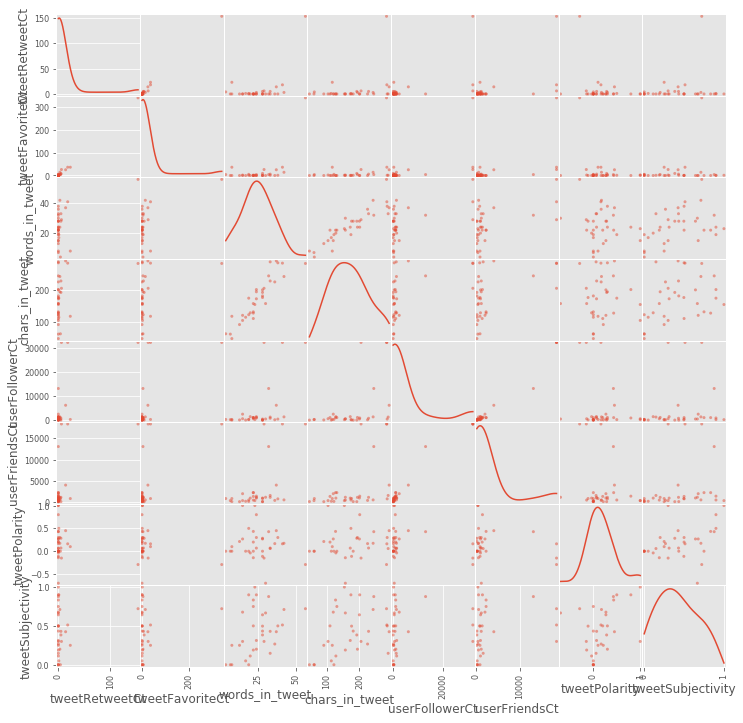

In [37]:
print('Scatter Matrix 1: Quantitative dimensions of tweets')
_ = pd.plotting.scatter_matrix(gdf[tweets_quant_dims], diagonal='kde', figsize=(12,12))

In [38]:
display_df_html(gdf[tweets_quant_dims].describe())

,tweetRetweetCt,tweetFavoriteCt,words_in_tweet,chars_in_tweet,userFollowerCt,userFriendsCt,tweetPolarity,tweetSubjectivity
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,6.941176,15.176471,24.911765,172.558824,3966.676471,2844.147059,0.170807,0.433519
std,26.366808,57.919731,11.125640,69.205969,9195.176403,5384.969700,0.334820,0.296257
min,0.000000,0.000000,4.000000,47.000000,42.000000,122.000000,-0.700000,0.000000
25%,0.000000,0.000000,19.000000,120.500000,241.000000,384.750000,0.000000,0.212500
50%,0.000000,1.000000,24.000000,173.000000,609.000000,911.500000,0.130952,0.427500
75%,3.000000,4.750000,31.500000,220.000000,1356.000000,1537.750000,0.295833,0.674621
max,153.000000,338.000000,56.000000,291.000000,32109.000000,18380.000000,1.000000,1.000000


In [39]:
len(gdf[gdf['tweetPolarity'] == 0]) / len(gdf)

0.20588235294117646

In [40]:
pd.set_option('display.max_colwidth', 0)
display_df_html(gdf.sample(min(100, len(gdf)))[['userScreen', 'tweetFullText', 'tweetPolarity']])

# Reset to default:
pd.set_option('display.max_colwidth', 50)


,userScreen,tweetFullText,tweetPolarity
124,agpcuk,"#BREXIT Hey boys I gotta Leave Deal, was easy, They get all our money, we get to leave EU Whatcha Fink? https://t.co/t827C3xlV4",0.433333
166,wdukegraphics,‘Welcome to the Zoo’\n\nA project based on creating a photomontage from images found in Magazines and Newspapers \n\n#photography #photomontage #design #GraphicDesign #Brexit #Trump https://t.co/fgQ5TL4kfn,0.800000
14,igniteseriousp,cosas curiosas que te puedes encontrar en unas vacaciones de Semana Santa en @LEGOLANDWindsor sobre #lego #london #brexit #downingstreet #easter #holiday #familytime #fun https://t.co/tKZRZL2SF0,0.300000
137,Miss_Helliwell,"My neighbours have been asking if this is my #Brexit bunker! Nope, it’s just the toddler toy shed! https://t.co/lj5BF84XMu",0.000000
171,BD_Stew,"Interesting article &amp; impressive ship, but worth noting it is actually owned by a partnership between Dutch &amp; Icelandic fishing companies - calling itself 'UK Fisheries'\n\nUK's biggest #fishing trawler sails up Thames in #Brexit warning https://t.co/7aUdGJDfy4 https://t.co/uIewqMmFHG",0.450000
152,nickreeves9876,We've been seeing political parties trying to lay claim to being 'the' anti-Brexit party. This is dishonest and self-defeating. The Remain movement is cross-party and non-party. \n#PeoplesVote #Brexit #FBPE,-0.150000
46,Massie68,"After a fabulous weekend in the glorious sunshine, it now Back to #brexit with a bang ☹️ It’s uglier as ever !",0.200000
165,LorraineWillis1,#EU PLOT: Brussels plans HUGE new powers - including IGNORING states on crunch decisions https://t.co/hHgzHBeFce\n#Brexit,0.268182
17,SloughForEU,Remain voters must not get complacent about the EU elections.\nIf remain supporting parties do not win the most seats it will massively set back any chance of any sort of People's Vote\n#Brexit #PeoplesVote\nhttps://t.co/CbspfJOA9Y,0.070000
123,agpcuk,Bercow is a disgrace he's totally Biased has a Balls to #BREXIT sticker in car rear window.A pompous Prat https://t.co/pnVkmcX09e,0.000000


In [41]:
gdf[tweets_quant_dims].corr()

,tweetRetweetCt,tweetFavoriteCt,words_in_tweet,chars_in_tweet,userFollowerCt,userFriendsCt,tweetPolarity,tweetSubjectivity
tweetRetweetCt,1.000000,0.997304,0.501817,0.325926,0.606723,0.570548,-0.242454,0.149622
tweetFavoriteCt,0.997304,1.000000,0.522197,0.335302,0.628821,0.592380,-0.246979,0.159535
words_in_tweet,0.501817,0.522197,1.000000,0.905622,0.530727,0.527463,-0.122036,0.423235
chars_in_tweet,0.325926,0.335302,0.905622,1.000000,0.462547,0.476263,0.040191,0.370598
userFollowerCt,0.606723,0.628821,0.530727,0.462547,1.000000,0.983153,-0.195666,0.155285
userFriendsCt,0.570548,0.592380,0.527463,0.476263,0.983153,1.000000,-0.167760,0.223450
tweetPolarity,-0.242454,-0.246979,-0.122036,0.040191,-0.195666,-0.167760,1.000000,0.376449
tweetSubjectivity,0.149622,0.159535,0.423235,0.370598,0.155285,0.223450,0.376449,1.000000


In [42]:
gdf[[ 'tweetRetweetCt',
       'tweetFavoriteCt', 'userFollowerCt', 'userFriendsCt',
        'lat',  'lon', 'tweetPolarity',
       'tweetSubjectivity', 'words_in_tweet', 'chars_in_tweet',
       'district_cd']].kurt()

tweetRetweetCt       30.946679
tweetFavoriteCt      31.792895
userFollowerCt        6.331016
userFriendsCt         4.765545
lat                  -1.583542
lon                  -1.325607
tweetPolarity         1.871856
tweetSubjectivity    -1.008254
words_in_tweet        0.666499
chars_in_tweet       -0.777387
dtype: float64

## Summary Statistics

### Referendum results

Across the UK, 382 districts are included in the dataset; of 33,551,983 valid votes cast in the Brexit referendum, 17,410,742 (51.89%) indicated Leave and 16,141,241 (48.11%) were cast to Remain. On average, 73.75% of a district's eligible electorate turned out to vote in the referendum. Across districts, a mean of 52.99% of voters indicated Leave and 47.01% voted Remain; the average proportional spread in vote outcome was 5.98%, in favor of "Leave". These statistics are not weighted by population, explaining the difference between the mean percentage of voters indicating Leave across districts and the overall outcome.

The smallest constituency - the Isles of Scilly - recorded 1,424 valid votes, while the largest - Northern Ireland - recorded 790,149. This figure, however, is due to the UK Electoral Commission's decision to merge the 18 constituencies into one in the dataset provided. Birmingham was the largest unmerged Local Area District, with 450,702 recorded valid votes. 

The most pro-Leave district was Boston, with over 75% of voters selecting Leave; 91.82% of voters in Gibraltar selected Remain, making it the most pro-Remain district. The most pro-Remain district within the home nations was the London borough of Lambeth, where 78.62% of voters elected not to withdraw from the EU.

In [43]:
valid_votes_sum = brexit_results['Valid_Votes'].sum()
leave_sum = brexit_results['Leave'].sum()
remain_sum = brexit_results['Remain'].sum()

print("Of {} valid votes cast in the Brexit referendum, {} \
voted to Leave and {} voted to remain.".format(valid_votes_sum, leave_sum, remain_sum))

Of 33551983 valid votes cast in the Brexit referendum, 17410742 voted to Leave and 16141241 voted to remain.


In [44]:
areas_results_cols = ['Area',  'Electorate', 'Valid_Votes', 'Remain', 'Leave', 'Pct_Turnout', 'Pct_Remain', 'Pct_Leave', 'Pct_Delta', 'st_areasha', 'dist_to_capital', 'pop_density']

In [45]:
areas_results_summary = areas_results[areas_results_cols].describe()
areas_results_summary

,Electorate,Valid_Votes,Remain,Leave,Pct_Turnout,Pct_Remain,Pct_Leave,Pct_Delta,st_areasha,dist_to_capital,pop_density
count,3.820000e+02,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,3.800000e+02,382.000000,380.000000
mean,1.217278e+05,87832.416230,42254.557592,45577.858639,73.754764,47.010995,52.989005,-5.978010,6.054079e+08,2.258409,0.001033
std,9.706175e+04,63554.624962,35622.620732,31308.892098,5.099413,10.696521,10.696521,21.393042,1.596640e+09,1.871399,0.001465
min,1.799000e+03,1424.000000,803.000000,621.000000,56.250000,24.440000,4.090000,-51.120000,2.903926e+06,0.000000,0.000007
25%,7.252375e+04,54844.250000,23535.250000,28668.500000,70.270000,39.655000,47.142500,-20.690000,8.626056e+07,0.831591,0.000140
50%,9.642550e+04,72511.500000,33475.000000,37573.500000,74.345000,45.735000,54.265000,-8.530000,2.643948e+08,1.931917,0.000393
75%,1.413798e+05,104332.000000,48245.500000,54137.500000,77.905000,52.857500,60.345000,5.715000,6.098404e+08,3.170273,0.001513
max,1.260955e+06,790149.000000,440707.000000,349442.000000,83.640000,95.910000,75.560000,91.820000,2.616280e+10,16.234814,0.009727


Figure 1: Brexit referendum results - boxplots


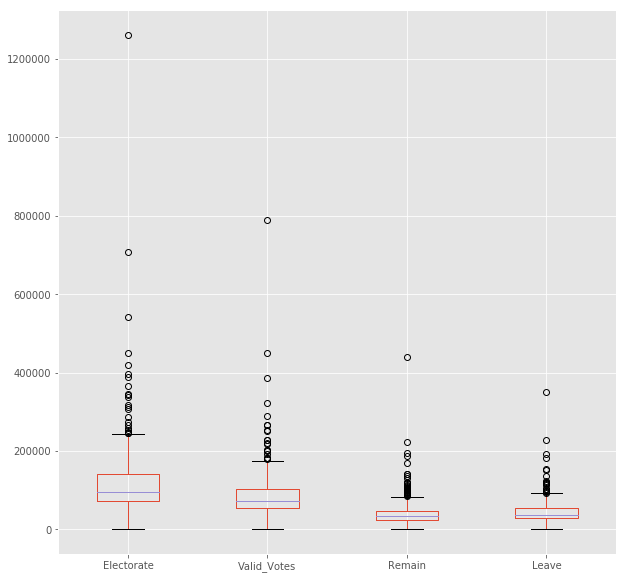

In [46]:
print("Figure 1: Brexit referendum results - boxplots")
boxplot_cols = [col for col in areas_results_cols if 'Pct' not in col and "area" not in col and 'pop' not in col and 'dist' not in col]
_ = areas_results[boxplot_cols].boxplot(figsize=(10,10))

Figure 2: Normalized Brexit referendum results - boxplots


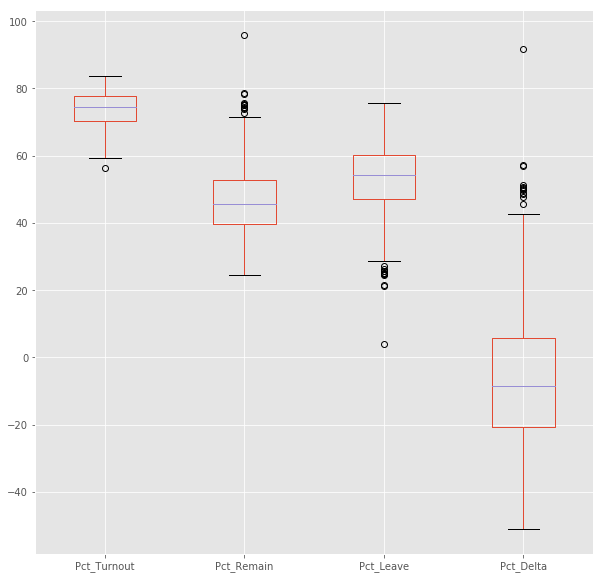

In [47]:
print("Figure 2: Normalized Brexit referendum results - boxplots")
boxplot_cols = [col for col in areas_results_cols if 'Pct' in col ]
_ = areas_results[boxplot_cols].boxplot(figsize=(10,10))

### Visualizing quantitative relationships

Comparing quantitative dimensions against each other in Scatter Matrix 2 reveals certain relationships contained in the data. 

Scatter Matrix 2: Brexit referendum results


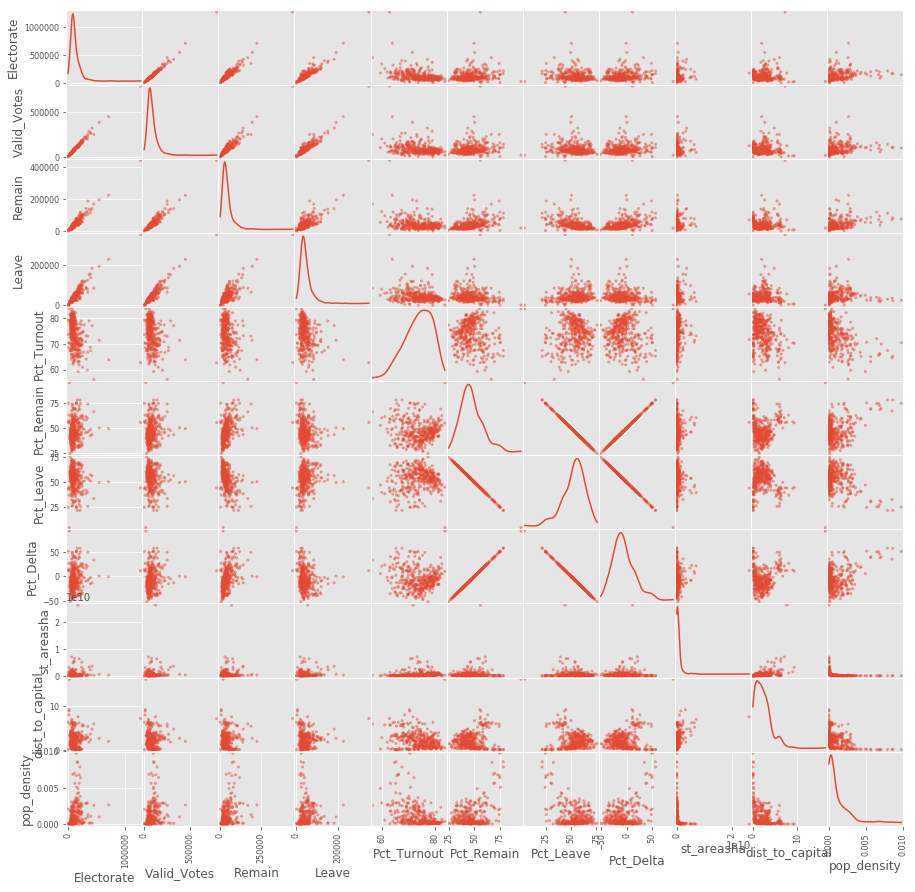

In [48]:
# First, narrow down columns to compare
print("Scatter Matrix 2: Brexit referendum results")
_ = pd.plotting.scatter_matrix(areas_results[areas_results_cols], figsize=(15,15), diagonal='kde')

##### Percent turnout vs Percent delta in voting outcome

Turnout is weakly correlated with a district's voting outcome - 0.0858 for Leave and -0.0858 for Remain. Of course, this is closely related to the overall outcome of the vote. However, its weak correlation suggests that neither side of the issue tended ot inspire a greater level of interest leading to engagement, an insight corroborated by the small margin of victory for the Leave campaign.

Map 3 depicts a choropleth of percent turnout by district area. Spatial patterns in England are of interest: outside of London, turnout tended to diminish as latitude increased. Areas of higher population density tended to have lower turnout (r = -0.4738).

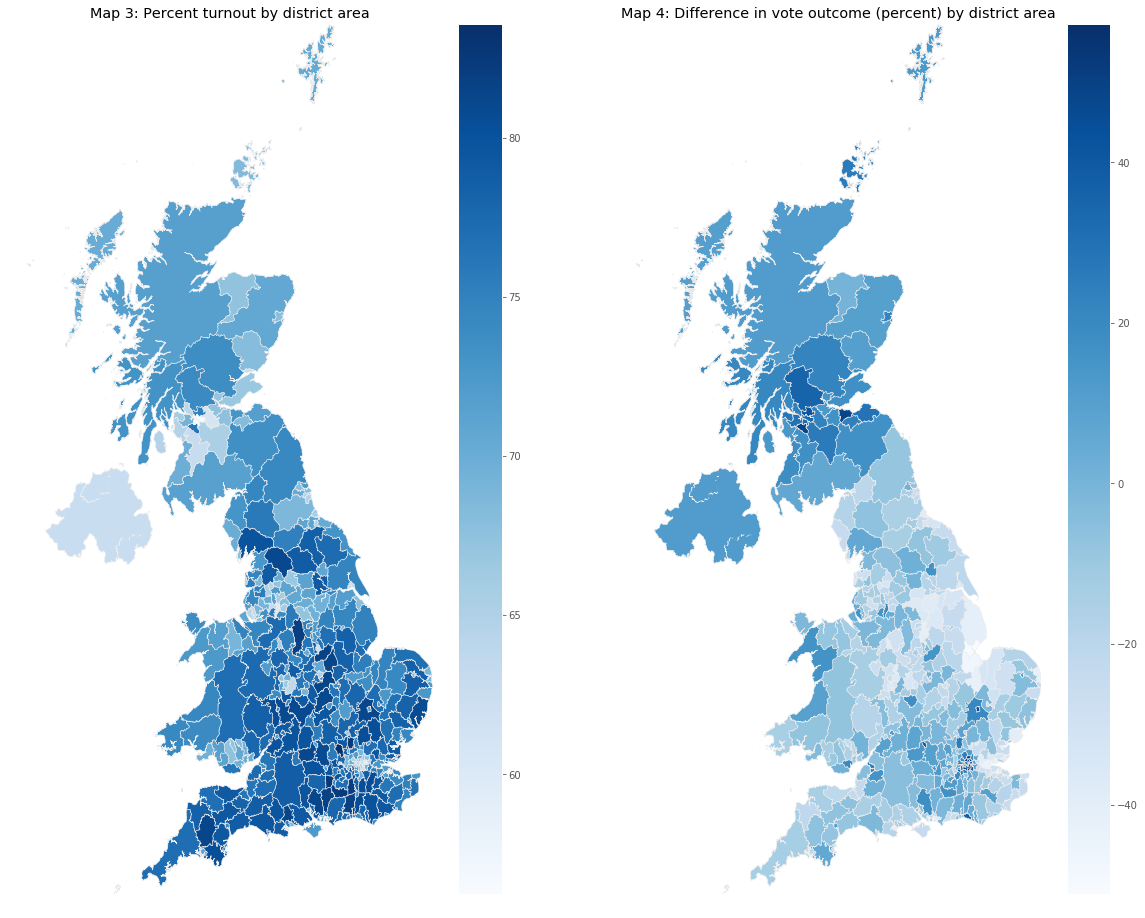

In [49]:
fig = plt.figure(figsize=(20, 16))

ax1  = plt.subplot(121)

_ = gplt.choropleth( areas_results[without_gibraltar], hue='Pct_Turnout', cmap='Blues',  k=None, legend=True, ax=ax1)
_ = plt.title('Map 3: Percent turnout by district area')

ax2  = plt.subplot(122)
_ = gplt.choropleth( areas_results[without_gibraltar], hue='Pct_Delta', cmap='Blues', k=None, legend=True, ax=ax2)
_ = plt.title('Map 4: Difference in vote outcome (percent) by district area')


**Legend**

**Map 3**: White - Lower turnout. Blue - Higher turnout.

**Map 4**: White - More voting for Leave. Blue - More voting for Remain.

##### Population Density vs Percent Remain

A positive correlation between population density and the percentage of voters choosing Remain (r = 0.4043) suggests that urban areas typically contained more pro-Remain voters, while rural ones tended to vote Leave. This evidence supports  observations commonly made in mainstream media regarding the disparity between urban and rural political sentiments (Beckett 2016, Rachman 2018).

##### Distance to London vs voting outcome

We also calculated the distance of each district area's centroid to the centroid of Westminster, to assess if a correlation exists between the distance to the capital and voting outcome. A Pearson's correlation coefficient of 0.1919 calculated on the plot of the percentage of voters selecting Remain against relative distance to Westminster suggests that a weak positive relationship exists: the further a district was from London, the more likely it was to select Remain. 

To further investigate this relationship we disaggregated observations by home nation. Figure 2 reveals an interesting pattern: Scottish districts tended to be both the furthest from London and to witness a greater percentage of voters selecting "Remain". We explore patterns found in data disaggregated by home nation below.

In [50]:
areas_results[areas_results_cols].corr()

,Electorate,Valid_Votes,Remain,Leave,Pct_Turnout,Pct_Remain,Pct_Leave,Pct_Delta,st_areasha,dist_to_capital,pop_density
Electorate,1.000000,0.992667,0.956608,0.926628,-0.381095,0.148778,-0.148778,0.148778,0.060821,0.085659,0.286055
Valid_Votes,0.992667,1.000000,0.955819,0.942411,-0.303008,0.142121,-0.142121,0.142121,0.077782,0.056097,0.240115
Remain,0.956608,0.955819,1.000000,0.802459,-0.310033,0.382402,-0.382402,0.382402,0.080830,0.078504,0.365512
Leave,0.926628,0.942411,0.802459,1.000000,-0.262335,-0.146596,0.146596,-0.146596,0.063101,0.024552,0.069829
Pct_Turnout,-0.381095,-0.303008,-0.310033,-0.262335,1.000000,-0.085769,0.085769,-0.085769,0.046423,-0.255160,-0.473767
Pct_Remain,0.148778,0.142121,0.382402,-0.146596,-0.085769,1.000000,-1.000000,1.000000,0.082537,0.191917,0.404320
Pct_Leave,-0.148778,-0.142121,-0.382402,0.146596,0.085769,-1.000000,1.000000,-1.000000,-0.082537,-0.191917,-0.404320
Pct_Delta,0.148778,0.142121,0.382402,-0.146596,-0.085769,1.000000,-1.000000,1.000000,0.082537,0.191917,0.404320
st_areasha,0.060821,0.077782,0.080830,0.063101,0.046423,0.082537,-0.082537,0.082537,1.000000,0.380463,-0.217112
dist_to_capital,0.085659,0.056097,0.078504,0.024552,-0.255160,0.191917,-0.191917,0.191917,0.380463,1.000000,-0.360400


### England

Every district in Scotland voted to remain; all but 5 of the 22 in Wales voted to Leave. Here we examine patterns across England's 326 districts, in 80 of which most voters selected 'Remain'.

##### Distance to London vs Remain voters

Within England, a negative correlation exists (r = -0.3213) between distance to the capital and percent of electorate voting Remain: English voters residing further from London tended to vote Leave more often. Complementing this, there appears to be a cluster of observations near London where over approximately 63% percent voted Remain (Figure 2). 

In [51]:
wales_results = areas_results[areas_results['home_nation'] == 'Wales']
print("In", str(len(wales_results[wales_results['Pct_Remain'] > 50])), "Welsh districts a majority voted 'Remain'")

In 5 Welsh districts a majority voted 'Remain'


In [52]:
scotland_results = areas_results[areas_results['home_nation'] == 'Scotland']
print("In", str(len(scotland_results[scotland_results['Pct_Remain'] > 50])), "Scottish districts a majority voted 'Remain'")

In 32 Scottish districts a majority voted 'Remain'


In [53]:
england_results = areas_results[areas_results['home_nation'] == 'England']
print("In", str(len(england_results[england_results['Pct_Remain'] > 50])), "English districts a majority voted 'Remain'")

In 80 English districts a majority voted 'Remain'


Figure 3: Percent voting Remain versus Distance to capital by home nation


<Figure size 720x720 with 0 Axes>

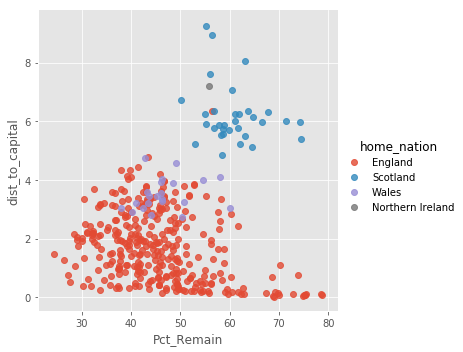

In [54]:
print('Figure 3: Percent voting Remain versus Distance to capital by home nation')
_ = plt.figure(figsize=(10,10))
_ = sns.lmplot(x="Pct_Remain", y="dist_to_capital", data=areas_results[without_gibraltar][['Pct_Remain', 'dist_to_capital', 'home_nation']], fit_reg=False, hue='home_nation', legend=True)


In [55]:
display_df_html(areas_results.groupby('home_nation').describe()[[ 'Pct_Remain', 'Pct_Leave']])

In [56]:
england_results.groupby('Region').mean()[['Pct_Turnout']].sort_values('Pct_Turnout', ascending=False)

,Pct_Turnout
Region,
South West,77.338378
South East,77.050448
East,75.741702
East Midlands,75.452250
West Midlands,74.534333
Yorkshire and The Humber,72.319048
North West,70.738974
London,69.817273
North East,69.130833


In [57]:
england_results.groupby('Region').mean()[['Pct_Delta']].sort_values('Pct_Delta', ascending=False)

,Pct_Delta
Region,
London,21.816970
South East,-4.340000
South West,-7.368649
North West,-11.830256
East,-13.924255
Yorkshire and The Humber,-17.300000
North East,-18.958333
East Midlands,-19.149000
West Midlands,-20.629333


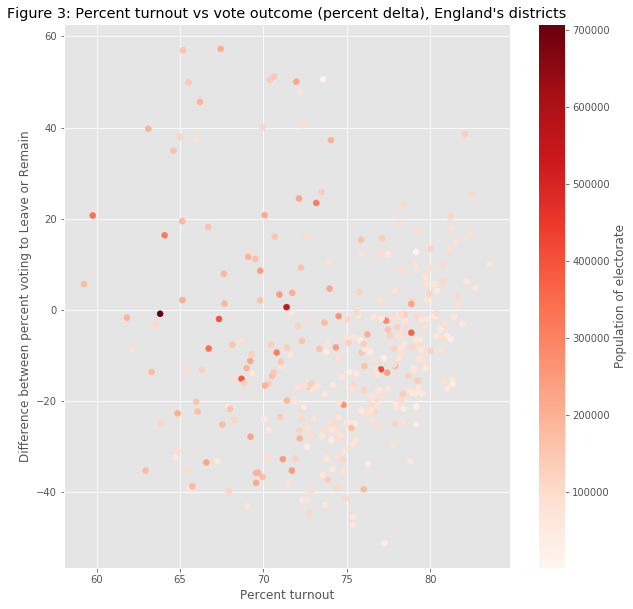

In [58]:
plt.figure(figsize=(10,10))
plt.title('Figure 3: Percent turnout vs vote outcome (percent delta), England\'s districts')
plt.xlabel('Percent turnout')
plt.ylabel('Difference between percent voting to Leave or Remain')

_ = plt.scatter(areas_results[areas_results['home_nation'] == 'England']['Pct_Turnout'], 
                areas_results[areas_results['home_nation'] == 'England']['Pct_Delta'], 
                c=areas_results[areas_results['home_nation'] == 'England']['Electorate'], 
                cmap='Reds')
_ = plt.colorbar(label='Population of electorate')

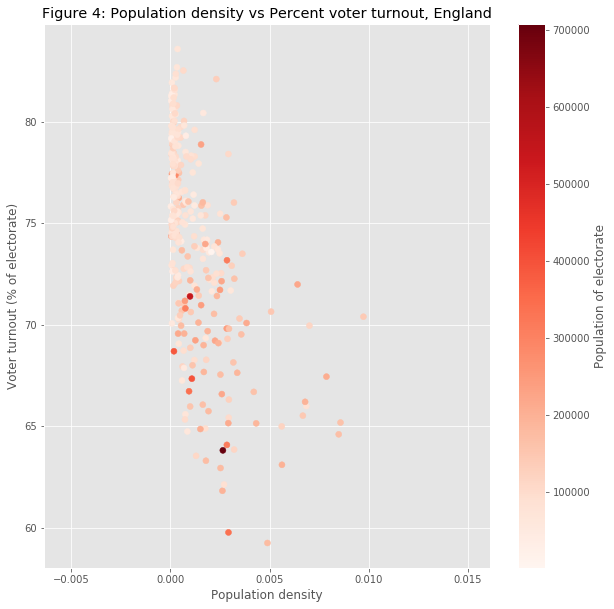

In [59]:
plt.figure(figsize=(10,10))
plt.title('Figure 4: Population density vs Percent voter turnout, England')
plt.xlabel('Population density')
plt.ylabel('Voter turnout (% of electorate)')

_ = plt.scatter(areas_results[areas_results['home_nation'] == 'England']['pop_density'], 
                areas_results[areas_results['home_nation'] == 'England']['Pct_Turnout'], 
                c=areas_results[areas_results['home_nation'] == 'England']['Electorate'], 
                cmap='Reds')
_ = plt.colorbar(label='Population of electorate')

In [60]:
england_results[['Pct_Turnout', 'Pct_Delta', 'pop_density', 'dist_to_capital', 'Pct_Remain']].corr()

,Pct_Turnout,Pct_Delta,pop_density,dist_to_capital,Pct_Remain
Pct_Turnout,1.000000,0.008777,-0.587061,-0.120828,0.008777
Pct_Delta,0.008777,1.000000,0.527068,-0.321281,1.000000
pop_density,-0.587061,0.527068,1.000000,-0.357552,0.527068
dist_to_capital,-0.120828,-0.321281,-0.357552,1.000000,-0.321281
Pct_Remain,0.008777,1.000000,0.527068,-0.321281,1.000000


Scatter Matrix 3: Distance to capital, Percent voting for Remain and Percent Turnout - English districts


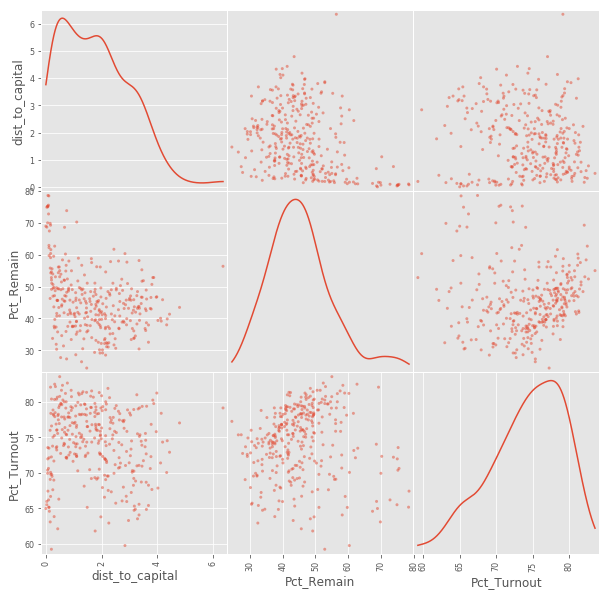

In [61]:
print("Scatter Matrix 3: Distance to capital, Percent voting for Remain and Percent Turnout - English districts")
_ = pd.plotting.scatter_matrix(england_results[['dist_to_capital', 'Pct_Remain', 'Pct_Turnout']], 
                               figsize=(10,10), 
                               diagonal='kde')


In [62]:
print('Brexit referendum results correlation matrix - England')

areas_results[areas_results['home_nation'].str.contains('Eng')][['Electorate', 'Remain', 'Leave', 'Pct_Turnout', 'Pct_Remain',
       'Pct_Leave', 'dist_to_capital', 'Pct_Delta', 'pop_density']].corr()

Brexit referendum results correlation matrix - England


,Electorate,Remain,Leave,Pct_Turnout,Pct_Remain,Pct_Leave,dist_to_capital,Pct_Delta,pop_density
Electorate,1.000000,0.933072,0.925246,-0.422415,0.178495,-0.178495,0.085845,0.178495,0.280769
Remain,0.933072,1.000000,0.756104,-0.301961,0.478979,-0.478979,-0.043807,0.478979,0.392319
Leave,0.925246,0.756104,1.000000,-0.307813,-0.142466,0.142466,0.188733,-0.142466,0.027319
Pct_Turnout,-0.422415,-0.301961,-0.307813,1.000000,0.008777,-0.008777,-0.120828,0.008777,-0.587061
Pct_Remain,0.178495,0.478979,-0.142466,0.008777,1.000000,-1.000000,-0.321281,1.000000,0.527068
Pct_Leave,-0.178495,-0.478979,0.142466,-0.008777,-1.000000,1.000000,0.321281,-1.000000,-0.527068
dist_to_capital,0.085845,-0.043807,0.188733,-0.120828,-0.321281,0.321281,1.000000,-0.321281,-0.357552
Pct_Delta,0.178495,0.478979,-0.142466,0.008777,1.000000,-1.000000,-0.321281,1.000000,0.527068
pop_density,0.280769,0.392319,0.027319,-0.587061,0.527068,-0.527068,-0.357552,0.527068,1.000000


In [63]:
print("Brexit referendum results correlation matrix - all districts")
areas_results[areas_results_cols].corr()

Brexit referendum results correlation matrix - all districts


,Electorate,Valid_Votes,Remain,Leave,Pct_Turnout,Pct_Remain,Pct_Leave,Pct_Delta,st_areasha,dist_to_capital,pop_density
Electorate,1.000000,0.992667,0.956608,0.926628,-0.381095,0.148778,-0.148778,0.148778,0.060821,0.085659,0.286055
Valid_Votes,0.992667,1.000000,0.955819,0.942411,-0.303008,0.142121,-0.142121,0.142121,0.077782,0.056097,0.240115
Remain,0.956608,0.955819,1.000000,0.802459,-0.310033,0.382402,-0.382402,0.382402,0.080830,0.078504,0.365512
Leave,0.926628,0.942411,0.802459,1.000000,-0.262335,-0.146596,0.146596,-0.146596,0.063101,0.024552,0.069829
Pct_Turnout,-0.381095,-0.303008,-0.310033,-0.262335,1.000000,-0.085769,0.085769,-0.085769,0.046423,-0.255160,-0.473767
Pct_Remain,0.148778,0.142121,0.382402,-0.146596,-0.085769,1.000000,-1.000000,1.000000,0.082537,0.191917,0.404320
Pct_Leave,-0.148778,-0.142121,-0.382402,0.146596,0.085769,-1.000000,1.000000,-1.000000,-0.082537,-0.191917,-0.404320
Pct_Delta,0.148778,0.142121,0.382402,-0.146596,-0.085769,1.000000,-1.000000,1.000000,0.082537,0.191917,0.404320
st_areasha,0.060821,0.077782,0.080830,0.063101,0.046423,0.082537,-0.082537,0.082537,1.000000,0.380463,-0.217112
dist_to_capital,0.085659,0.056097,0.078504,0.024552,-0.255160,0.191917,-0.191917,0.191917,0.380463,1.000000,-0.360400


## Temporal Autocorrelation

Twitter is designed as a platform for sharing perspectives with the world in real time. As such, tweets are timestamped to the second. As part of our analysis we investigated temporal trends in when tweets were posted. This analysis is constrained in that Twitter does not provide developers access to its complete corpus of tweets. Instead, the company's API returns a subset of tweets matching query parameters; the criteria by which these tweets are selected is not public. 

Acknowledging this constraint, Twitter claims to provide a random sample of tweets posted that match query parameters (Twitter Developers 2019). Given that tweets included were all posted from within UK territory - Greenwich Mean Time +/- 1 - and that tweets are posted by members of the public, we expect to observe strong daily temporal cyclicity. We do not anticipate a non-stationary trend to exist in observed hourly tweet frequencies.

In [64]:
df_ts = df.groupby(pd.Grouper(key='tweetCreated', freq='3600s')).count()

Examining a line graph of hourly unique tweet frequencies, a cycle on a 24-hour period clearly exists, with fewer tweets being created during the British night. 

On 1 and 2 April a relatively high number of unique tweets were observed in the dataset. This requires further investigation, but we believe the high tweet volume on 1 April 2019 may have been due to the UK Parliament holding an indicative vote (UK Parliament 2019), meant to offer MPs an opportunity to find non-binding consensus on next steps in the Brexit process. Results of the vote were delivered by the Speaker of the House of Commmons Rt Honourable John Bercow at 22:04 on 1 April 2019 (House of Commons 2019); the peak number of unique tweets were posted in the hour prior to that moment. The spike in tweet volumes on 2 April 2019 may be due to Prime Minister Theresa May delivering a speech regarding a No Deal Brexit (GOV.UK 2019).

Note: This plot will not match the analysis provided.


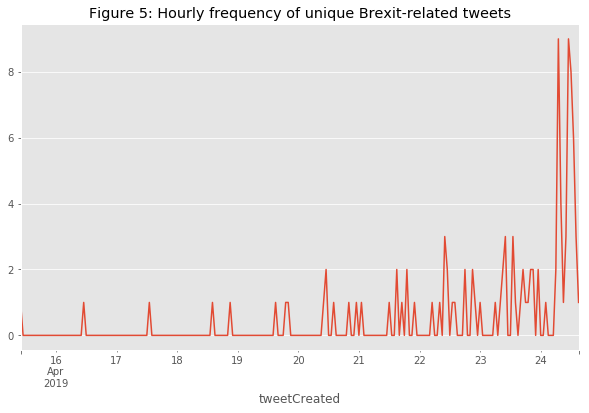

In [65]:
if execute != 'local':
    print('Note: This plot will not match the analysis provided.')
    
_ = df_ts['tweetID'].plot.line(title="Figure 5: Hourly frequency of unique Brexit-related tweets", figsize=(10,6))

Plotting autocorrelation of the number of unique tweets posted per hour reveals positive correlation on a 24 hour cycle. This is in line with expectations, and is likely because all districts under consideration - where all tweets were either posted from, or where all tweet creators indicate is their location - exist in timezones within an hour of each other. We expect less Twitter activity in these areas at night, and more during the day, when residents are awake and active. While evidence of lower tweet volumes during weekend days (6 and 7 April 2019) may exist, our datasest does not span enough time to draw any meaningful conclusions in this regard.

| District area | Timezone | 
| --- | --- |
| Northern Ireland | GMT +1 | 
| England, Wales and Scotland | GMT +1 | 
| Gibraltar | GMT +2 |

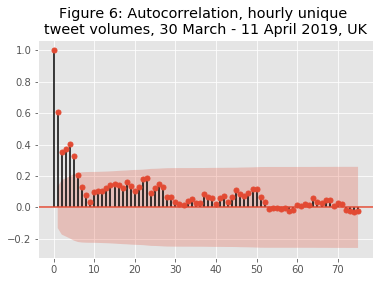

In [66]:
_ = plot_acf(df_ts['tweetID'], lags=75)
_ = plt.title('Figure 6: Autocorrelation, hourly unique \ntweet volumes, 30 March - 11 April 2019, UK')

### Tweet Distribution

We examined how collected tweets were distributed across the district areas included in our study. Here we compare normalized values representing the number of tweets collected and the electorate populations in each district. We test whether proportionate values differ significantly with a dependent t-test for paired samples, and visualize the distributions with choropleths and a spatial kernel density estimation plot overlaid on the district polygon geometries.

In [67]:
areas_results_sentiments['tweet_count'] = areas_results_sentiments['tweetPolarity_count']

In [68]:
areas_results_sentiments.sort_values('tweet_count', ascending=False)

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,...,tweetPolarity_max,tweetSubjectivity_count,tweetSubjectivity_mean,tweetSubjectivity_std,tweetSubjectivity_min,tweetSubjectivity_25%,tweetSubjectivity_50%,tweetSubjectivity_75%,tweetSubjectivity_max,tweet_count
35,43.0,E06000043,Brighton and Hove,None,530279.0,106849.0,-0.15079,50.846489,8.278527e+07,59061.901424,...,0.267857,5.0,0.521952,0.167123,0.300000,0.433333,0.511905,0.642857,0.721667,5.0
257,258.0,E08000001,Bolton,None,368352.0,409873.0,-2.47952,53.584492,1.397920e+08,82647.144256,...,1.000000,5.0,0.371190,0.444793,0.000000,0.000000,0.189286,0.666667,1.000000,5.0
13,14.0,E06000014,York,None,460864.0,452589.0,-1.07375,53.965820,2.719370e+08,101957.577302,...,0.800000,3.0,0.678704,0.239153,0.425000,0.568056,0.711111,0.805556,0.900000,3.0
71,38.0,E06000038,Reading,None,470226.0,173154.0,-0.99071,51.453018,4.039799e+07,39330.830216,...,0.500000,3.0,0.441667,0.409331,0.112500,0.212500,0.312500,0.606250,0.900000,3.0
187,188.0,E07000165,Harrogate,None,427473.0,464652.0,-1.58161,54.077080,1.309128e+09,246964.632102,...,0.268182,3.0,0.314646,0.341176,0.000000,0.133333,0.266667,0.471970,0.677273,3.0
30,31.0,E06000031,Peterborough,None,517372.0,300777.0,-0.26874,52.592140,3.433782e+08,112678.098853,...,0.100000,2.0,0.125000,0.176777,0.000000,0.062500,0.125000,0.187500,0.250000,2.0
99,88.0,E07000048,Christchurch,None,413093.0,96313.0,-1.81570,50.766251,5.037565e+07,64049.975042,...,0.433333,2.0,0.791667,0.058926,0.750000,0.770833,0.791667,0.812500,0.833333,2.0
161,162.0,E07000133,Melton,None,477328.0,323472.0,-0.85440,52.803291,4.813805e+08,140629.596847,...,0.427778,2.0,0.463889,0.585327,0.050000,0.256944,0.463889,0.670833,0.877778,2.0
212,213.0,E07000195,Newcastle-under-Lyme,None,378199.0,345174.0,-2.32631,53.003448,2.109573e+08,108259.276988,...,0.212500,2.0,0.375000,0.176777,0.250000,0.312500,0.375000,0.437500,0.500000,2.0
7,8.0,E06000008,Blackburn with Darwen,None,369490.0,422806.0,-2.46360,53.700802,1.370221e+08,65284.992754,...,0.300000,1.0,0.500000,NaN,0.500000,0.500000,0.500000,0.500000,0.500000,1.0


In [69]:
# Calculate normalized samples
areas_results_sentiments['num_tweets_norm'] = areas_results_sentiments['tweet_count'] / areas_results_sentiments['tweet_count'].max()
areas_results_sentiments['num_electorate_norm'] = areas_results_sentiments['Electorate'] / areas_results_sentiments['Electorate'].max()

In [70]:
df_ttest = areas_results_sentiments.dropna(subset=['num_tweets_norm', 'num_electorate_norm'])

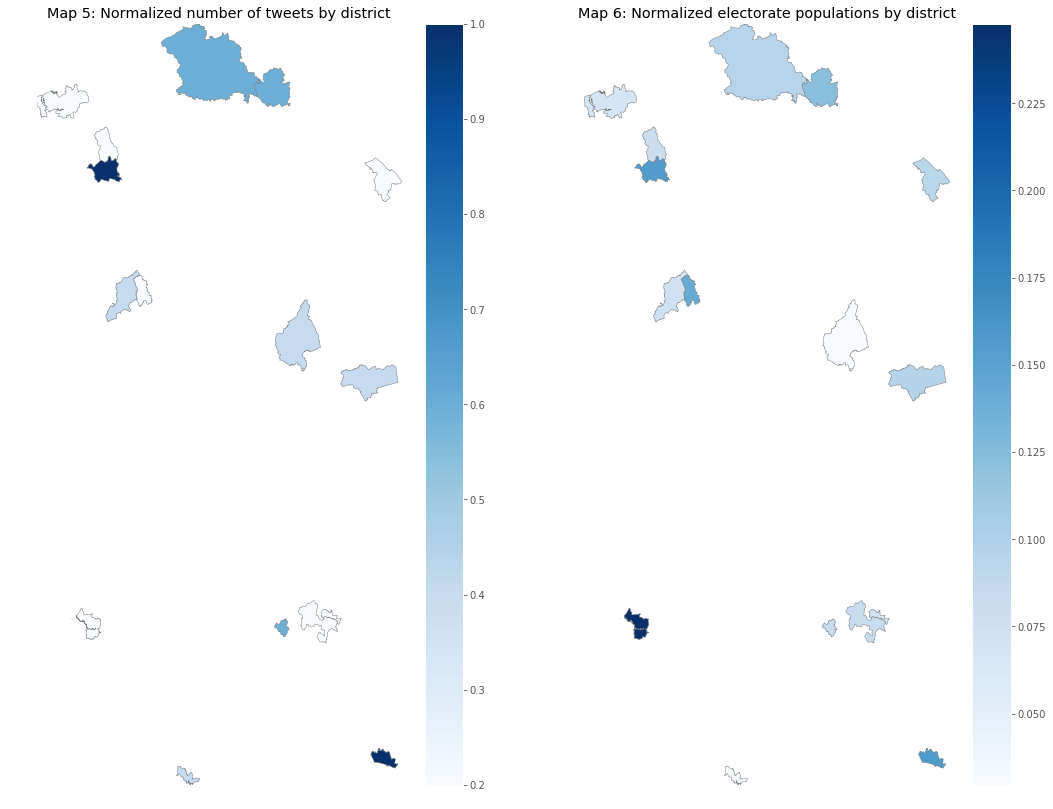

In [71]:
fig = plt.figure(figsize=(18, 14))

ax1  = plt.subplot(121)

_ = gplt.choropleth( df_ttest, 
                    hue='num_tweets_norm', 
                    cmap='Blues', 
                    k=None, 
                    legend=True, 
                    ax=ax1,
                    linewidth=0.5, 
                    edgecolor='gray')

_ = plt.title('Map 5: Normalized number of tweets by district')

ax2  = plt.subplot(122)
_ = gplt.choropleth(df_ttest, 
                    hue='num_electorate_norm', 
                    cmap='Blues', 
                    k=None, 
                    legend=True, 
                    ax=ax2,
                    linewidth=0.5, 
                    edgecolor='gray')

_ = plt.title('Map 6: Normalized electorate populations by district')


**Legend**

Map 5: White - Fewer tweets. Blue -  More tweets.

Map 6: White - Smaller electoral population. Blue - Larger electoral population.

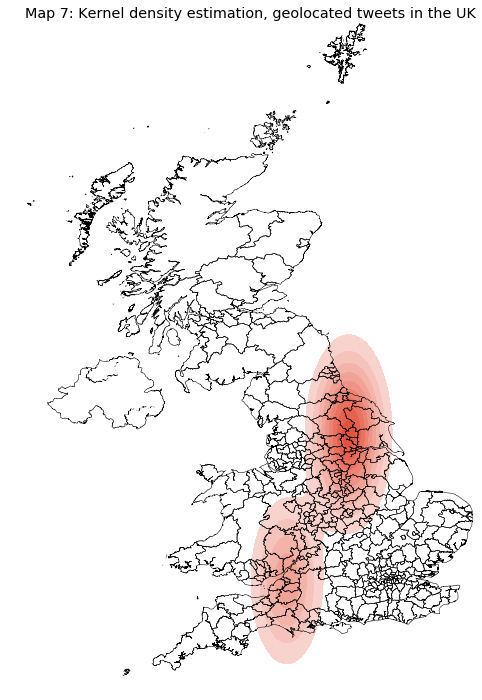

In [72]:
ax = gplt.kdeplot(gdf.sample(frac=0.1),
                     shade=True, 
                     shade_lowest=False,
                     figsize=(8,12))
_ = gplt.polyplot(areas_results_sentiments[without_gibraltar], ax=ax)
_ = plt.title("Map 7: Kernel density estimation, geolocated tweets in the UK")

**Legend**

Areas of deeper red indicate larger densities of tweets observed.

### Testing tweet distribution

Ten districts did not contain any of the tweets collected, in spite of our efforts to scrape content for each area. An average of 69.54 tweets were collected in each district, with a standard deviation of 136.31 and a maximum of 1,069. We suspect this observed maximum is located in Westminster because the point returned by the geolocation API for "London" falls within the borough. 

A positive correlation exists in the relationship between normalized tweet counts and normalized electorate populations (Pearson's r=0.4249). However, several of the districts with large numbers of tweets seem unlikely to be so well represented on Twitter: for example, Wiltshire, England and Ceredigion, Wales - two fairly rural districts with low population densities - are among the districts with the most tweets, while Hammersmith and Fulham, a densely-populated London borough, only has two tweets geocoded within its borders.

To test whether tweet counts are proportionate to a district's electorate population, we conducted a dependent t-test for paired samples. Tweets are, in theory, posted by people, meaning the number of tweets posted from a geography is not independent of the number of people residing in that geography. The search parameters employed did not request a proportionate number of tweets from each district. Despite this, we opted to run the test because only 25.80% of geocoded tweets were contained within the district area geometry for which they were originally retrieved. 

An alpha level of 0.05 will be used to evaluate whether normalized tweet counts (mean=0.06505, standard deviation=0.1275) differ significantly from normalized electorate populations (mean=0.09765, standard deviation=0.07746). Our sample contains 372 pairs of observation (degrees of freedom=371). 

**Null hypothesis:** *The number of tweets collected in each district are proportionate to the electorate population.*

**Alternate hypothesis:** *The proportionate number of tweets collected differs significantly from the proportionate populations of the electorates in district areas in the UK.*

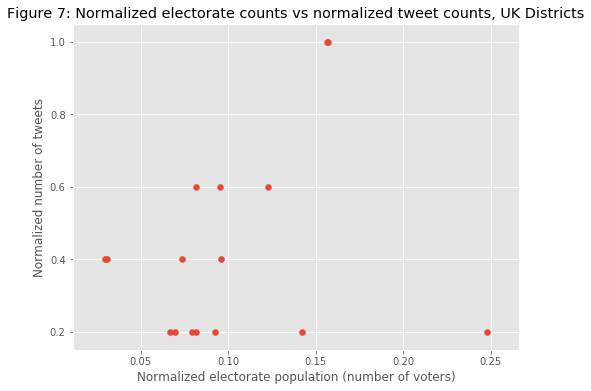

In [73]:
plt.figure(figsize=(8,6))
plt.title("Figure 7: Normalized electorate counts vs normalized tweet counts, UK Districts")
plt.xlabel('Normalized electorate population (number of voters)')
plt.ylabel('Normalized number of tweets')
_ = plt.scatter(df_ttest['num_electorate_norm'], df_ttest['num_tweets_norm'])

In [74]:
len(gdf[gdf['searchArea'] == gdf['district_cd']]) / len(gdf) 

0.4117647058823529

In [75]:
df_ttest[['num_tweets_norm', 'num_electorate_norm']].describe()

,num_tweets_norm,num_electorate_norm
count,16.000000,16.000000
mean,0.425000,0.101450
std,0.272029,0.054267
min,0.200000,0.029559
25%,0.200000,0.072628
50%,0.400000,0.087027
75%,0.600000,0.127776
max,1.000000,0.247800


Text(0.5, 1.0, 'Figure 8: Normalized tweet and electorate counts per district')

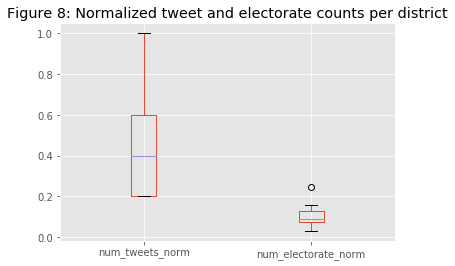

In [76]:
_ = df_ttest[['num_tweets_norm', 'num_electorate_norm']].boxplot()
plt.title('Figure 8: Normalized tweet and electorate counts per district')

In [77]:
df_ttest[['num_tweets_norm', 'num_electorate_norm']].corr()

,num_tweets_norm,num_electorate_norm
num_tweets_norm,1.000000,0.233348
num_electorate_norm,0.233348,1.000000


In [78]:
# Perform test and print results
tweet_dist_ttest = scipy.stats.ttest_rel(df_ttest['num_tweets_norm'], df_ttest['num_electorate_norm'])

print("t = " + str(tweet_dist_ttest[0].round(4)))
print("p = " + str('{:.11f}'.format(tweet_dist_ttest[1])))

t = 4.8897
p = 0.00019625565


##### Dependent paired t-test results

A t-statistic of -5.3396, along with the test's 371 degrees of freedom, corresponds to a p-value of 0.00000016272. This alpha value is less than our threshold of 0.05; we reject the null hypothesis that tweet counts are proportionate to the population of the electorate. This result means that some areas contained different numbers of geolocated tweets than would have been expected if tweet counts were proportionate to the observed electorate populations in each district. The possible causes for this are myriad, including:

- Twitter is more commonly used by various sub-populations than others, which may be unevenly distributed in the country. 
- The Twitter API may return tweets that are not entirely representative of the tweets posted from different areas. 
- The geolocation API employed returned a specific point for location names encompassing multiple districts. For example, "London" returned a point in Westminster, even though it is unlikely that every Twitter user listing "London" as their location resides in Westminster.

Aware that normalized tweet counts differ significantly from normalized electorate counts, we continue our analysis.

### District-level Sentiments

The tweet polarity dimension derived from the `TextBlob.sentiment` attribute provides a measure of a sentence's negative or positive tone. However, the analyzer employed was not able to detect the subject of the tweet - if it was referring to Brexit itself, to an event or figure involved, or any of myriad other topics related to the issue. At this point in our analysis we suspect that our initial assumption that tweets containing "#brexit" refer to the topic, and therefore a measure of a relevant tweet's polarity would be an indicator of the tweeter's view on Brexit, fails to capture the complexity of computational analysis of such a subjective and complex issue. 

Based on our sentiment analyzer, we calculated summary statistics of tweet polarity and subjectivity for each district in our study. 


In [79]:
display_df_html(areas_results_sentiments[['tweetPolarity_mean', 'tweetSubjectivity_mean']].describe())

,tweetPolarity_mean,tweetSubjectivity_mean
count,16.000000,16.000000
mean,0.213216,0.408843
std,0.254306,0.176901
min,-0.112500,0.125000
25%,0.056250,0.310985
50%,0.191572,0.406667
75%,0.287500,0.497917
max,1.000000,0.791667


In [80]:
areas_results_sentiments['tweet_count_log'] = np.log(areas_results_sentiments['tweet_count'])

In [81]:
areas_results_sentiments.sort_values('tweet_count', ascending=False)

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,...,tweetSubjectivity_std,tweetSubjectivity_min,tweetSubjectivity_25%,tweetSubjectivity_50%,tweetSubjectivity_75%,tweetSubjectivity_max,tweet_count,num_tweets_norm,num_electorate_norm,tweet_count_log
35,43.0,E06000043,Brighton and Hove,None,530279.0,106849.0,-0.15079,50.846489,8.278527e+07,59061.901424,...,0.167123,0.300000,0.433333,0.511905,0.642857,0.721667,5.0,1.0,0.157256,1.609438
257,258.0,E08000001,Bolton,None,368352.0,409873.0,-2.47952,53.584492,1.397920e+08,82647.144256,...,0.444793,0.000000,0.000000,0.189286,0.666667,1.000000,5.0,1.0,0.156317,1.609438
13,14.0,E06000014,York,None,460864.0,452589.0,-1.07375,53.965820,2.719370e+08,101957.577302,...,0.239153,0.425000,0.568056,0.711111,0.805556,0.900000,3.0,0.6,0.123047,1.098612
71,38.0,E06000038,Reading,None,470226.0,173154.0,-0.99071,51.453018,4.039799e+07,39330.830216,...,0.409331,0.112500,0.212500,0.312500,0.606250,0.900000,3.0,0.6,0.081821,1.098612
187,188.0,E07000165,Harrogate,None,427473.0,464652.0,-1.58161,54.077080,1.309128e+09,246964.632102,...,0.341176,0.000000,0.133333,0.266667,0.471970,0.677273,3.0,0.6,0.095156,1.098612
30,31.0,E06000031,Peterborough,None,517372.0,300777.0,-0.26874,52.592140,3.433782e+08,112678.098853,...,0.176777,0.000000,0.062500,0.125000,0.187500,0.250000,2.0,0.4,0.095873,0.693147
99,88.0,E07000048,Christchurch,None,413093.0,96313.0,-1.81570,50.766251,5.037565e+07,64049.975042,...,0.058926,0.750000,0.770833,0.791667,0.812500,0.833333,2.0,0.4,0.031069,0.693147
161,162.0,E07000133,Melton,None,477328.0,323472.0,-0.85440,52.803291,4.813805e+08,140629.596847,...,0.585327,0.050000,0.256944,0.463889,0.670833,0.877778,2.0,0.4,0.029559,0.693147
212,213.0,E07000195,Newcastle-under-Lyme,None,378199.0,345174.0,-2.32631,53.003448,2.109573e+08,108259.276988,...,0.176777,0.250000,0.312500,0.375000,0.437500,0.500000,2.0,0.4,0.073608,0.693147
7,8.0,E06000008,Blackburn with Darwen,None,369490.0,422806.0,-2.46360,53.700802,1.370221e+08,65284.992754,...,NaN,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,0.2,0.079398,0.000000


In [82]:
areas_results_sentiments.loc[areas_results_sentiments['tweetPolarity_mean'].isnull(), 'no_tweets'] = True
areas_results_sentiments['no_tweets'] = areas_results_sentiments['no_tweets'].fillna(False)
areas_results_sentiments['tweet_count_log'] = np.log(areas_results_sentiments['tweetPolarity_count'])

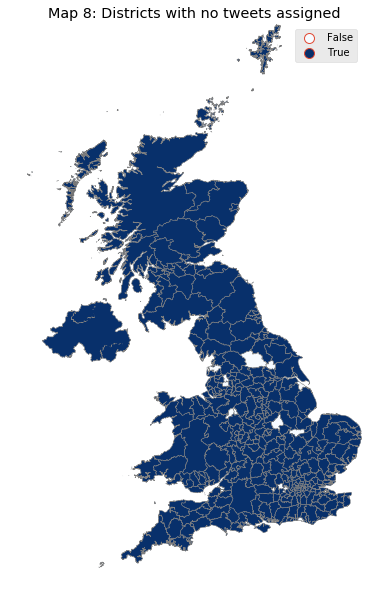

In [83]:
_ = gplt.choropleth(areas_results_sentiments[without_gibraltar], 
                hue='no_tweets', 
                figsize=(6,10), 
                legend=True, 
                cmap='Blues', 
                categorical=True, 
                linewidth=0.5, 
                edgecolor='gray')

_ = plt.title("Map 8: Districts with no tweets assigned")

### Comparing sentiment and vote outcome 

Here we investigate the relationship between computationally-detected sentiment of tweets related to Brexit in April 2019 and district area's voting outcome in the 2016 referendum. 

To statistically assess whether a district area's polarity relates to its voting outcome we will again conduct a dependent t-test for paired samples. Using an alpha value of 0.05, we will assess whether normalized percent delta values representing the difference in percentage voting Leave vs Remain differ significantly from mean tweet polarity values calculated for each district area. Both variables range from [-1, 1], with the greatest percent delta in favor of Remain being assigned -1, and the most negative Brexit-related tweets being assigned the same. TextBlob's polarity value is scaled from -1 to 1; only percent delta will need transformation to normalized values.

Based on our initial assumptions, it stands to reason that these variables are not independent: districts that supported Brexit should have a more positive view on the issue, and vice versa. However, as our exploratory analysis has progressed we have come to grasp the complexity of taking a computational approach to answering our research question. Tweets hardly represent the populace, and we have demonstrated that tweet counts are not proportionate to electorate counts in the UK districts considered. Furthermore, distilling the qualitative meaning of a statement (i.e. tweet) into a scalar value is necessarily reductionist; detecting the political orientation of the statement on the issue and the subject at which its polarity is directed was well beyond the scope of this effort, and possibly the capabilities of contemporary natural language processing techniques (cite).

Of note: observations containing null values in either dimension will be excluded from the test. This includes Gibraltar, which contains the maximum percent delta in favor of Remain. 

**Null hypothesis:** *Normalized differences in Brexit referendum vote outcome are proportionate to mean tweet polarity values in UK voting districts.*

**Alternate hypothesis:** *The normalized differences in vote outcome differ significantly from mean tweet polarity values across the UK.*

**Degrees of freedom:** *371*

In [84]:
df_ttest_sentiment = areas_results_sentiments[~areas_results_sentiments['tweetPolarity_mean'].isna()]

In [85]:
pct_delta_scale = max(abs(df_ttest_sentiment['Pct_Delta'].max()), abs(df_ttest_sentiment['Pct_Delta'].min()))

In [86]:
df_ttest_sentiment['pct_delta_norm'] = -1 * df_ttest_sentiment['Pct_Delta']  / pct_delta_scale

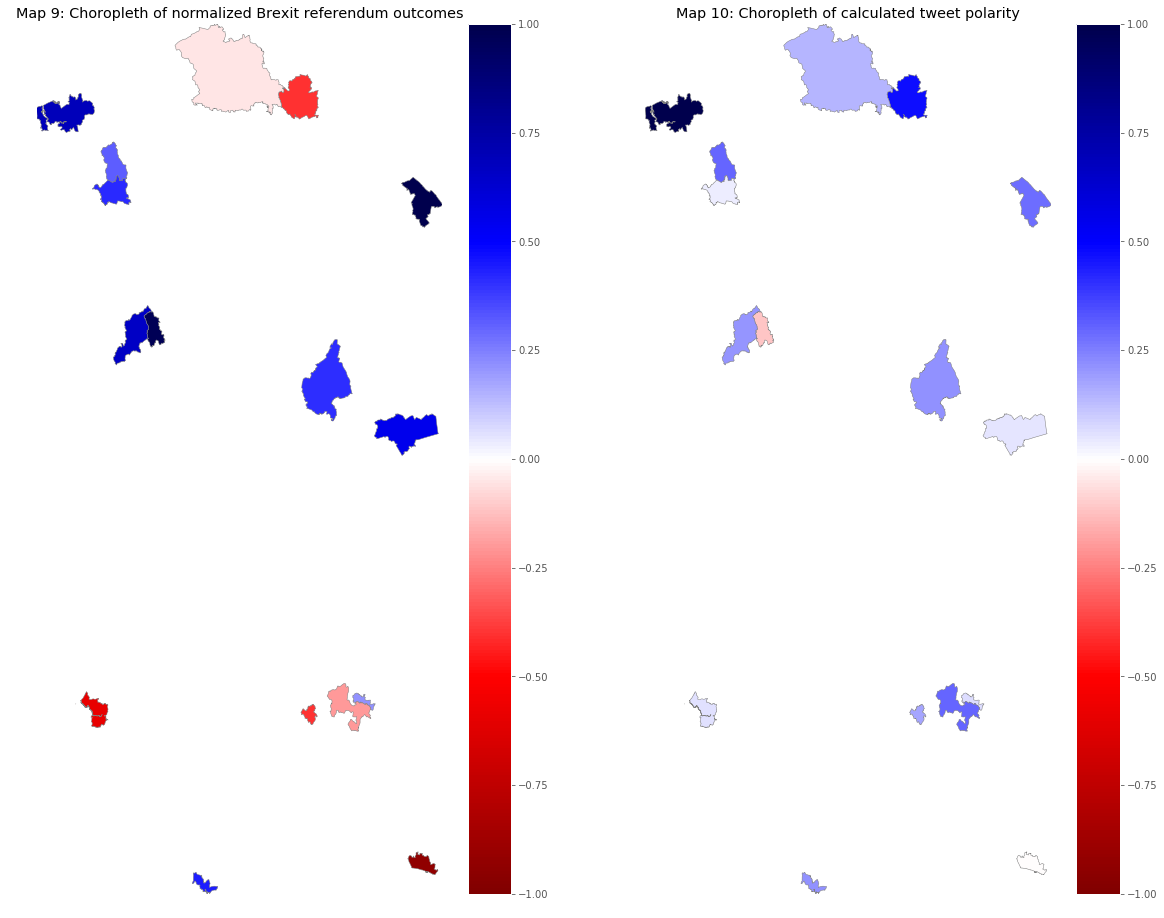

In [87]:
fig = plt.figure(figsize=(20, 16))

ax1  = plt.subplot(121)

# txt="-1: More voting for Remain  1: More voting for Leave"
# _ = ax1.text(1, 1, txt, wrap=True, horizontalalignment='right', fontsize=12)

_ = gplt.choropleth( df_ttest_sentiment, 
                    hue='pct_delta_norm', 
                    cmap='seismic_r', 
                    vmin=-1.0, 
                    vmax=1.0, 
                    k=None,
                    legend=True, 
                    ax=ax1,
                    linewidth=0.5, 
                    edgecolor='gray')

_ = plt.title('Map 9: Choropleth of normalized Brexit referendum outcomes')


ax2  = plt.subplot(122)

# txt="-1: Negative mean tweet polarity  1: Positive mean tweet polarity"
# _ = ax2.text(1, 1, txt, wrap=True, horizontalalignment='right', fontsize=12)

_ = gplt.choropleth( df_ttest_sentiment, 
                    hue='tweetPolarity_mean', 
                    cmap='seismic_r',
                    vmin=-1.0, 
                    vmax=1.0, 
                    k=None, 
                    legend=True, 
                    ax=ax2,
                    linewidth=0.5, 
                    edgecolor='gray')

_ = plt.title('Map 10: Choropleth of calculated tweet polarity')


**Legend**

Map 8: &emsp;-1: Negative mean tweet polarity &emsp; &emsp; &emsp; 1: Positive mean tweet polarity

Map 9: &emsp; -1: More voting for Remain &emsp; &emsp; &emsp;   &emsp; &emsp; 1: More voting for Leave

In [88]:
df_ttest_sentiment[['tweetPolarity_mean', 'pct_delta_norm']].describe()

,tweetPolarity_mean,pct_delta_norm
count,16.000000,16.000000
mean,0.213216,0.193571
std,0.254306,0.568222
min,-0.112500,-0.937091
25%,0.056250,-0.248239
50%,0.191572,0.363613
75%,0.287500,0.575113
max,1.000000,1.000000


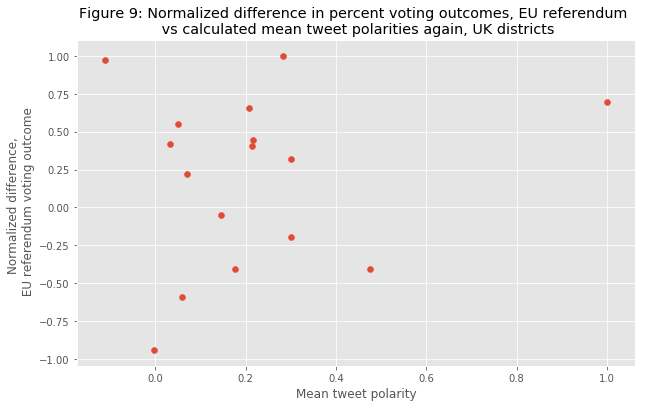

In [89]:
plt.figure(figsize=(10,6))
plt.title("Figure 9: Normalized difference in percent voting outcomes, EU referendum \n vs calculated mean tweet polarities again, UK districts")
plt.xlabel("Mean tweet polarity")
plt.ylabel("Normalized difference, \n EU referendum voting outcome")
_ = plt.scatter(df_ttest_sentiment['tweetPolarity_mean'], df_ttest_sentiment['pct_delta_norm'])

In [90]:
# Perform test and print results
sentiment_ttest = scipy.stats.ttest_rel(df_ttest_sentiment['tweetPolarity_mean'], df_ttest_sentiment['pct_delta_norm'])

print("t = " + str(sentiment_ttest[0].round(4)))
print("p = " + str('{:.21f}'.format(sentiment_ttest[1])))

t = 0.1337
p = 0.895428719456895949591


#### Dependent paired t-test results

With 371 degrees of freedom and a t-statistic of -2.077, a p-value of 0.03849 means we reject the null hypothesis that normalized differences in Brexit referendum vote outcome are proportionate to mean tweet sentiments in UK voting districts. Rather, the mean normalized "percent delta" is significantly higher than that of tweet polarity. 

While these two dimensions quantify quite different aspects of a district area, we sought to investigate their relationship because we suspected there might be a connection. This test indicates that no such connection exists; a Pearson's correlation coefficient of 0.02377 further suggests a very weak relationship. 

We feel, however, that this quantitative investigation does not provide a complete answer to our research question regarding the relationship of tweet sentiment and Brexit voting outcomes. Questions remain about the attitudes of the public towards the issue, as well as the best way to computationally assess the sentiment and subject of natural language.

In [91]:
df_ttest_sentiment[['tweetPolarity_mean','pct_delta_norm']].corr()

,tweetPolarity_mean,pct_delta_norm
tweetPolarity_mean,1.000000,0.145399
pct_delta_norm,0.145399,1.000000


Scatter Matrix 4: Sentiment-related quantitative dimenions


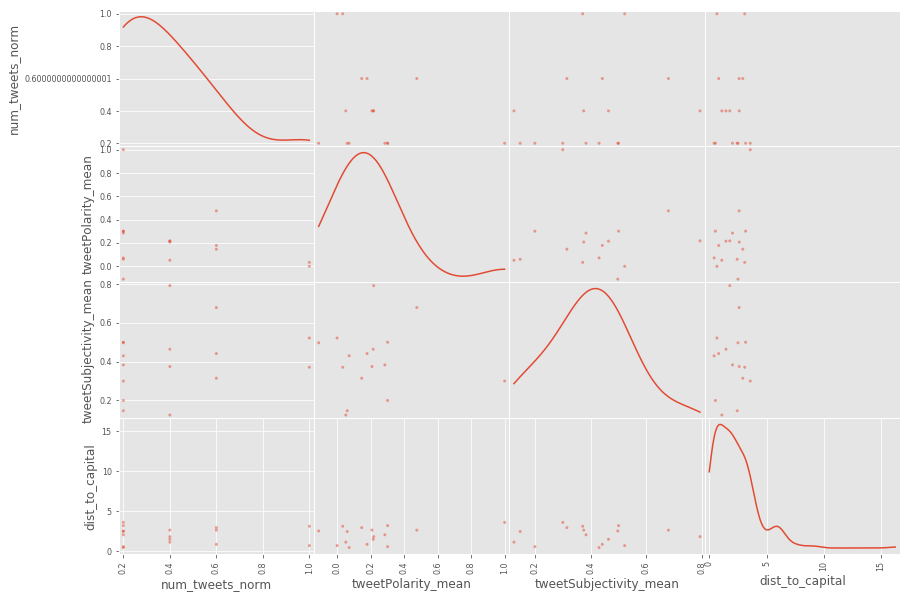

In [92]:
print("Scatter Matrix 4: Sentiment-related quantitative dimenions")
_= pd.plotting.scatter_matrix(areas_results_sentiments[['num_tweets_norm',
       'tweetPolarity_mean',
       'tweetSubjectivity_mean', 'dist_to_capital']], figsize=(14,10), diagonal='kde')

# Discussion

This investigation sought to assess the sentiments of residents of the United Kingdom towards Brexit as of April 2019. We combined a number of spatial, quantitative and natural language datasets in an effort to understand attitudes across the country, and how they related to voting outcomes in the 2016 referendum. 

Regarding our research question, few conclusions can be drawn on the basis of this analysis. Our approach to detecting tweet sentiment using a Naive Bayes classifier yielded an additional dimension to each tweet observation, but further analysis of this dimension did not produce much more information on the question. We believe this is due to the inherent constraints of analyzing a subjective statement in the computational manner employed. The nuance of meaning intrinsic to language makes algorithmic processing of natural language an incredibly difficult machine learning task. In this analysis, with this dataset relating to the subject of Brexit, we conclude that the Naive Bayes approach employed is inadequate for extracting meaningful information. 

Analysis of the spatial dataset joined with referendum results yielded interesting insights. Differences in voting patterns between different home nations were revealed. English and Welsh voters in less densely populated districts tended to support the Leave campaign at the ballot box, and ultimately won. Within England, distance from London was positively correlated with percentages voting to Leave. This insight may point to a gulf in perceived well-being and voters attitudes towards their future. Leave represented changing what was to come; Remain represented stay the course. While the reasons why are myriad and, at times, sinister (Stewart 2016), that a majority of British voters chose change and uncertainty over sameness should be understood by civic, business and academic leaders as a signal that change is needed, that many British people perceive flaws in the geopolitical system.

Discerning the reasons behind these voting trends is beyond the scope of this effort, but is worth investigation as they indicate a cleft in what the British demos perceives as the best way forward for their country. By simply abiding in a country, one participates in the national project; if national unity is valued by the British political class, developing a better understanding of the perceptions and motivations of their entire electorate is worthwhile.

# Conclusion

Our analysis of various Brexit-related spatial, quantitative and natural language datasets provided empirical evidence informing our understanding of voting trends across the country. We found that our approach to assessing public sentiment was inadequate, and reach no firm conclusions on perceptions of the British public across the UK on the issue. 

This effort uncovered many opportunities for further analysis. We identified the shortcomings of the Naive Bayes classification approach employed, but would be very interested in developing more sophisticated supervised classification techniques custom-designed for the task at hand. We suspect that our training set - movie reviews included in the NLTK corpus - was not particularly suitable for the data we sought to classify. While human coding a training set of tweets related to Brexit was beyond the scope of this analysis, creating such a training set might improve classification accuracy and, correspondingly, our ability to take Britain's pulse on the issue. We are also interested in investigating a more nuanced approach to natural language classification than simply assigning a Polarity and Subjectivity value to a statement.

Computational analysis of the complexities of meaning is incredibly difficult. While we do not write off the potential for natural language processing to automate the distillation of insight from large volumes of semi- or unstructured language data, we will carry our critical perspective forward in interpreting the findings of other researchers, and in our application to similar tasks. 

# References

BBC. 2019. *Brexit: May awaits EU Brexit extension decision.* [ONLINE] Available at: https://www.bbc.co.uk/news/uk-politics-47885145. [Accessed 22 April 2019].

Becker, Sascha, Fetzer, Thiemo and Novy, Dennis. 2017. *Who voted for Brexit? A comprehensive district-level analysis.* Economic Policy, Volume 32, Issue 92, October 2017 pp 601-650. Available at: https://academic.oup.com/economicpolicy/article/32/92/601/4459491. [Accessed 15 April 2019].

Beckett, Andy. 2016. *From Trump to Brexit, power has leaded from cities to the countryside.* The Guardian. [ONLINE] Available at: https://www.theguardian.com/commentisfree/2016/dec/12/trump-brexit-cities-countryside-rural-voters. [Accessed 15 April 2019].
    

Electoral Commission. 2019. *EU referendum results.* [ONLINE] Available at: https://www.electoralcommission.org.uk/find-information-by-subject/elections-and-referendums/past-elections-and-referendums/eu-referendum/electorate-and-count-information. [Accessed 1 April 2019].

European Council. 2019. *Brexit: European Council adopts decision extending the period under Article 50.* [ONLINE] Available at: https://www.consilium.europa.eu/en/press/press-releases/2019/03/22/brexit-european-council-adopts-decision-extending-the-period-under-article-50/. [Accessed 22 April 2019].

GOV.UK. 2019. *PM statement on Brexit: 2 April 2019 - GOV.UK.* [ONLINE] Available at: https://www.gov.uk/government/speeches/pm-statement-on-brexit-2-april-2019. [Accessed 15 April 2019]. 

House of Commons. 2019. *Parliamentlive.tv Monday 1 April 2019 Meeting.* [ONLINE] Available at: https://parliamentlive.tv/event/index/14b23cd1-9472-44ba-9742-dd2deec361d1?in=15:40:31. [Accessed 15 April 2019].

Kastrenakes, Jacob. 2019. *Twitter keeps losing monthly user, so it's going to stop sharing how many.* The Verge. [ONLINE] Available at: https://www.theverge.com/2019/2/7/18213567/twitter-to-stop-sharing-mau-as-users-decline-q4-2018-earnings. [Accessed 15 April 2019].

Kumar, Nikhil. 2019. *Twitter Sentiment Analysis using Python - GeeksforGeeks.* [ONLINE] Available at: https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/. [Accessed 22 April 2019]. 
       
Natural Earth. 2019. *10m-cultural-vectors.* [ONLINE] Available at: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/. [Accessed 1 April 2019]. 

ONS Geography. 2018. *Local Authority Districts (December 2017) Boundaries.* [ONLINE] Available at: https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2017-full-clipped-boundaries-in-great-britain. [Accessed 1 April 2019]. 

Ordnance Survey Northern Ireland. 2015. *OSNI Open Data 50k Admin Boundaries - Parliamentary Constituencies 2008.* [ONLINE] Available at: https://osni-spatial-ni.opendata.arcgis.com/datasets/ef212a5825514aa8b39259e54cbe87b1_3. [Accessed 1 April 2019].

Porcard, Giuseppe and Muller, Henrik. 2016. *Tweeting Brexit: Narrative building and sentiment analysis.* [ONLINE] Available at: http://bruegel.org/2016/11/tweeting-brexit-narrative-building-and-sentiment-analysis/. [Accessed 15 April 2019].

Rachman, Gideon. 2018. *Urban-rural splits have become the great global divider.* Financial Times. [ONLINE] Available at: https://www.ft.com/content/e05cde76-93d6-11e8-b747-fb1e803ee64e. [Accessed 15 April 2019].

Roesslin, Josh. 2010. *Tweepy.* [ONLINE] Available at: https://www.tweepy.org/. [Accessed 1 April 2019].

Satariano, Adam. 2019. *How the Internet Travels Across Oceans.* New York Times. [ONLINE] Available at: https://www.nytimes.com/interactive/2019/03/10/technology/internet-cables-oceans.html. [Accessed 15 April 2019].

Stewart, Heather and Mason, Rowena. 2016. *Nigel Farage's anti-migrant poster reported to police.* [ONLINE] Available at: https://www.theguardian.com/politics/2016/jun/16/nigel-farage-defends-ukip-breaking-point-poster-queue-of-migrants. [Accessed 15 April 2019].

Twitter Developers. 2019. *Using standard search.* [ONLINE] Available at: https://developer.twitter.com/en/docs/tweets/search/guides/standard-operators.html. [Accessed 15 April 2019]. 

UK Parliament. 2019. *House of Commons holds second round of indicative votes - News from Parliament - UK Parliament.* [ONLINE] Available at: https://www.parliament.uk/business/news/2019/april/house-of-commons-holds-second-round-of-indicative-votes/. [Accessed 15 April 2019]. 

Zhang, Harry. 2004. *The Optimality of Naive Bayes.* American Association for Articial Intelligence. [ONLINE] Available at: https://www.aaai.org/Papers/FLAIRS/2004/Flairs04-097.pdf. [Accessed 15 April 2019].

Contains public sector information licensed under the terms of the Open Government Licence v3.0. Made with Natural Earth.
